In [1]:
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
import pandas as pd #manipulacao de dados
from datetime import datetime, timedelta #manipulacao de datas
from netCDF4 import Dataset, date2index, num2date #manipulacao de arquivos nc
import conda
import numpy as np
import cftime
import matplotlib.cm as cm
import matplotlib.path as mpath
from cartopy import config
import cartopy.crs as ccrs

import scipy
from numpy import zeros
from scipy import signal
from scipy import misc 
import matplotlib.pylab as pylab

from scipy.fftpack import fft, dct
from scipy.fftpack import dct, idct
from numpy import empty,arange,exp,real,imag

from IPython.core.display import Image, display

import signalz
import padasip as pa #Filtros Adaptativos
import xarray as xr
import numpy.ma as ma
from scipy import ndimage

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from mpl_toolkits.basemap import Basemap
#from cartopy.util import add_cyclic_point

import cartopy.feature as cfeature
import shapely.geometry as sgeom
import random
from numpy import random

import plotly.express as px
import geopandas
import warnings

In [2]:
#Bloque_i = 2 #Para elegir que bloque quiero graficar y sus coordenadas
nxn, nxn16, nxn8 = 32,16,8 #Dimension de las caixas
Cn = 10 #Numero de caixas aleatorias creadas en la funcion X10
i1,i2 = 3,3
ze_ran = "zeros" #"random" #Para iniciar los coeficientes
p = 4 #ordem do filtro
N_r = 2 #Repeticion de las serie temporales x(k) y d(k)
eps0 = 1.0 #Multiplica a la matriz identidad, para iniciar. "0.1" da un poquito mas de error.
mu1 = 0.99 #Factor de esquecimento o aprendizaje

# (1). Datos de ERA5 e BESM:

In [3]:
era5y6_iNOV_entrenm = xr.open_dataset('/home/lugorio/Dados_BESM_ERA5/BESMyERA5_2005a2007_TESIS/ERA5/ERA7y8_NOV_OCT.nc')
era6y7_iNOV_ajst = xr.open_dataset('/home/lugorio/Dados_BESM_ERA5/BESMyERA5_2005a2007_TESIS/ERA5/ERA8y9_NOV_OCT.nc')

besm5y6_iNOV_entrenm = xr.open_dataset('/home/lugorio/Dados_BESM_ERA5/BESMyERA5_2005a2007_TESIS/BESM/BESM7y8_NOV_OCT.nc')
besm6y7_iNOV_ajst = xr.open_dataset('/home/lugorio/Dados_BESM_ERA5/BESMyERA5_2005a2007_TESIS/BESM/BESM8y9_NOV_OCT.nc')

In [4]:
E_ano_6 = era5y6_iNOV_entrenm["sst"]
B_ano_6 = besm5y6_iNOV_entrenm["surface_temp"]
E_ano_7 = era6y7_iNOV_ajst["sst"]
B_ano_7 = besm6y7_iNOV_ajst["surface_temp"]

E_ano_6.shape, B_ano_6.shape, E_ano_7.shape, B_ano_7.shape

((366, 720, 1440), (366, 720, 1440), (365, 720, 1440), (365, 720, 1440))

- Aumentando 3 dias al anual:

In [5]:
A1, A2, A3, A4 = 0, 365, 362, 365
Era_6 = xr.concat([E_ano_6[A1:A2,:,:],E_ano_6[A3:A4,:,:]], dim="time")
Besm_6 = xr.concat([B_ano_6[A1:A2,:,:],B_ano_6[A3:A4,:,:]], dim="time")
Era_7  = xr.concat([E_ano_7[A1:A2,:,:],E_ano_7[A3:A4,:,:]], dim="time")
Besm_7  = xr.concat([B_ano_7[A1:A2,:,:],B_ano_7[A3:A4,:,:]], dim="time")

#np.save('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/era_ano7y8_368dias',Era_6)
#np.save('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/besm_ano7y8_368dias',Besm_6)
#np.save('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/era_ano8y9_368dias',Era_7)
#np.save('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/besm_ano8y9_368dias',Besm_7)
#Era_6 =np.load('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/era_ano7y8_368dias.npy', mmap_mode='r')
#Besm_6 =np.load('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/besm_ano7y8_368dias.npy', mmap_mode='r')
#Era_7 =np.load('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/era_ano8y9_368dias.npy', mmap_mode='r')
#Besm_7 =np.load('/home/lugorio/Dados_BESM_ERA5/concat_368dias_articulo_tesis/besm_ano8y9_368dias.npy', mmap_mode='r')

Besm_7.shape, Era_7.shape, Besm_6.shape, Era_6.shape

((368, 720, 1440), (368, 720, 1440), (368, 720, 1440), (368, 720, 1440))

# (2). Caixas de NxN de cualquier bloque para trabajar:

In [6]:
has_nan = np.any(np.isnan(B_ano_7[:,34:36,650:680]))
# Imprimimos el resultado
if has_nan:
    print("La matriz contiene valores NaN")
else:
    print("La matriz no contiene valores NaN")

La matriz no contiene valores NaN


In [127]:
import random
# para no probar los 365, basta el primer dia, porque de 1 a 365 los "nan" se repiten.
def NaN_(M):
    array_ = M.ravel() #ravel convierte a un array de 1 dimension
    for i in range(array_.shape[0]): #len() dá o comprimento da 1eira dimensão #size() dará número total de elem.
        if np.isnan(array_[i]):
            return True
    return False

# n: dimension da caixa.
def CAIXA_aleat_01(M_besm_6,M_era_6,M_besm_7,M_era_7, n):
    R = 32 #Para descontar el numero de muestras.
    # Avezes da 99 porque alguna muestra debe estar con "NaN"
    Z_besm_6 = []
    Z_era_6 = []
    Z_besm_7 = []
    Z_era_7 = []
    W_besm_6 = []
    W_era_6 = []
    W_besm_7 = []
    W_era_7 = []
    X_besm_6 = []
    X_era_6 = []
    X_besm_7 = []
    X_era_7 = []
    x_i_1 = random.sample(range(140,320),Cn)
    x_f_1 = random.sample(range(1270,1300),Cn)
    x_i_2 = random.sample(range(520,580),Cn)
    x_f_2 = random.sample(range(0,220),Cn)
    x_i_3 = random.sample(range(360,600),Cn)
    x_f_3 = random.sample(range(1340,1400),Cn)
    x_i_4 = random.sample(range(540,550),Cn)
    x_f_4 = random.sample(range(1300,1350),Cn)
    x_i_5 = random.sample(range(390,550),Cn)
    x_f_5 = random.sample(range(300,370),Cn)
    x_i_6 = random.sample(range(220,250),Cn)
    x_f_6 = random.sample(range(1190,1330),Cn)
    x_i_7 = random.sample(range(200,320),Cn)
    x_f_7 = random.sample(range(620,680),Cn)
    x_i_8 = random.sample(range(190,350),Cn)
    x_f_8 = random.sample(range(860,900),Cn)
    x_i_9 = random.sample(range(190,370),Cn)
    x_f_9 = random.sample(range(740,765),Cn)
    x_i_10 = random.sample(range(350,600),Cn+10)
    x_f_10 = random.sample(range(780,1070),Cn+10)
    x_i_11 = random.sample(range(570,580),Cn)
    x_f_11 = random.sample(range(330,600),Cn)
    x_i_12 = random.sample(range(0,5),Cn-6)
    x_f_12 = random.sample(range(0,5),Cn-6)
    x_i_13 = random.sample(range(0,5),Cn-6)
    x_f_13 = random.sample(range(500,535),Cn-6)
    x_i_14 = random.sample(range(550,620),Cn-6)
    x_f_14 = random.sample(range(1250,1255),Cn-6)
    x_i = x_i_1+x_i_2+x_i_3+x_i_4+x_i_5+x_i_6+x_i_7+x_i_8+x_i_9+x_i_10+x_i_11+x_i_12+x_i_13+x_i_14
    x_f = x_f_1+x_f_2+x_f_3+x_f_4+x_f_5+x_f_6+x_f_7+x_f_8+x_f_9+x_f_10+x_f_11+x_f_12+x_f_13+x_f_14
    for i in range(len(x_i)):
        Z_besm_6.append(M_besm_6[:,x_i[i]:x_i[i]+n,x_f[i]:x_f[i]+n]) #n: dimenção da caixa
        Z_era_6.append(M_era_6[:,x_i[i]:x_i[i]+n,x_f[i]:x_f[i]+n])
        Z_besm_7.append(M_besm_7[:,x_i[i]:x_i[i]+n,x_f[i]:x_f[i]+n]) #n: dimenção da caixa
        Z_era_7.append(M_era_7[:,x_i[i]:x_i[i]+n,x_f[i]:x_f[i]+n])
    W_besm_6 = np.asarray(Z_besm_6)
    W_era_6 = np.asarray(Z_era_6)
    W_besm_7 = np.asarray(Z_besm_7)
    W_era_7 = np.asarray(Z_era_7)
    for x in range(0,len(x_i)):
        if NaN_(W_besm_6[x][0]) == False:
            X_besm_6.append(W_besm_6[x])
        if NaN_(W_era_6[x][0]) == False:
            X_era_6.append(W_era_6[x])
        if NaN_(W_besm_7[x][0]) == False:
            X_besm_7.append(W_besm_7[x])
        if NaN_(W_era_7[x][0]) == False:
            X_era_7.append(W_era_7[x])
    return(np.asarray(X_besm_6[0:len(X_era_6)-R]), np.asarray(X_era_6[0:len(X_era_6)-R]), np.asarray(X_besm_7[0:len(X_era_6)-R]), np.asarray(X_era_7[0:len(X_era_6)-R]),x_i, x_f)

In [128]:
Caixas_besm_era = CAIXA_aleat_01(Besm_6,Era_6,Besm_7,Era_7, nxn)
Caixas_besm_era[0].shape, Caixas_besm_era[1].shape ,Caixas_besm_era[2].shape, Caixas_besm_era[3].shape 

((100, 368, 32, 32),
 (100, 368, 32, 32),
 (100, 368, 32, 32),
 (100, 368, 32, 32))

- Para graficar un bloque aletorio:

In [9]:
xx_i = Caixas_besm_era[-2]
xx_f = Caixas_besm_era[-1]

Bloque_i = random.randint(0, Caixas_besm_era[0].shape[0])-1 #Ponemos 4 para que no pase del Cn
coorde_BLOQUE_aleat_E7 = Era_7[:,xx_i[Bloque_i]:xx_i[Bloque_i]+nxn,xx_f[Bloque_i]:xx_f[Bloque_i]+nxn]
coorde_BLOQUE_aleat_B7 = Besm_7[:,xx_i[Bloque_i]:xx_i[Bloque_i]+nxn,xx_f[Bloque_i]:xx_f[Bloque_i]+nxn]

coorde_BLOQUE_aleat_E6 = Era_6[:,xx_i[Bloque_i]:xx_i[Bloque_i]+nxn,xx_f[Bloque_i]:xx_f[Bloque_i]+nxn]
coorde_BLOQUE_aleat_B6 = Besm_6[:,xx_i[Bloque_i]:xx_i[Bloque_i]+nxn,xx_f[Bloque_i]:xx_f[Bloque_i]+nxn]
coorde_BLOQUE_aleat_E7.shape, coorde_BLOQUE_aleat_B7.shape

((368, 32, 32), (368, 32, 32))

In [10]:
len(xx_i), len(xx_f)

(132, 132)

# (3). Seleccionando coordenadas:

In [11]:
# Solo hay 2 opciones en Longitud y 2 opciones en Latitud: "positivos o negativos"
def COORDENADA(M,dia,Pixel_comp_lon,Pixel_comp_lat):
    lon, lat = ((M[dia,:,Pixel_comp_lon]["longitude"]+180)%360)-180, M[dia,Pixel_comp_lat,:]["latitude"]
    if (lon > 0) and (lat > 0) :
        return(float(lon), float(lat))#return(float(lon),"°E ", float(lat), "°N")
    if (lon > 0) and (lat < 0) :
        return(float(lon), float(lat))#return(float(lon),"°E ", float(lat), "°S")
    if (lon < 0) and (lat < 0) :
        return(float(lon), float(lat))#return(float(lon),"°W ", float(lat), "°S")
    if (lon < 0) and (lat > 0) :
        return(float(lon),float(lat))#return(float(lon),"°W ", float(lat), "°N")
    if (lon > 0) and (lat == 0) :
        return(float(lon),float(lat))#return(float(lon),"°E ", float(lat), "°")
    if (lon < 0) and (lat == 0) :
        return(float(lon),float(lat))#return(float(lon),"°W ", float(lat), "°")
    if (lon == 0) and (lat > 0) :
        return(float(lon),float(lat))#return(float(lon),"° ", float(lat), "°N")
    if (lon == 0) and (lat < 0) :
        return(float(lon),float(lat))#return(float(lon),"° ", float(lat), "°S")

# (4). Graficando los pixeles(células) analizadas:

In [12]:
type(xx_i), len(xx_i)

(list, 132)

In [13]:
def COORDENADAS_TRABAJO(M,lat,lon):
    Z_1 = []
    Z_2 = []
    for i in range(0,len(lat)):
        Z_1.append(COORDENADA(M[:,xx_i[i]:xx_i[i]+nxn,xx_f[i]:xx_f[i]+nxn],0,3,3)[1])
        Z_2.append(COORDENADA(M[:,xx_i[i]:xx_i[i]+nxn,xx_f[i]:xx_f[i]+nxn],0,3,3)[0])
    return(Z_1, Z_2)        

In [14]:
puntos_coord_1 = COORDENADAS_TRABAJO(Era_7,xx_i,xx_f)
type(puntos_coord_1[0])

list

In [15]:
puntos_coord = {'Latitude_0':puntos_coord_1[0],
                'Longitude_1':puntos_coord_1[1],
               }
coord_escogida_2 = {
   'Lat': [COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]], 
   'Lon': [COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]],
}
#puntos_coord
coord_escogida_2

{'Lat': [-59.25], 'Lon': [-46.0]}

- Aqui seleccionamos solo el punto analisado para graficar

In [16]:
coord_aleat_selec = ["%s%s%s%s"%("lat=",COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1], ", lon=",COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0])]
coord_aleat_selec

['lat=-59.25, lon=-46.0']

Text(0.5, 1.0, "Pixeis aleatórios corrigidos com 'CMV' e 'RLS' ")

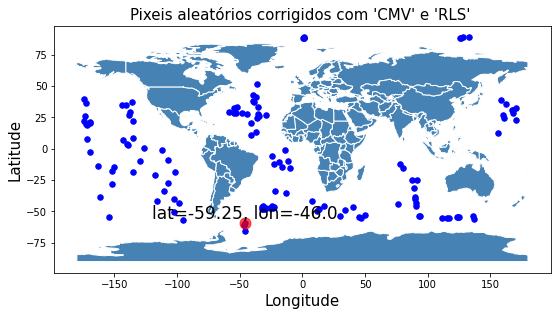

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
starbucks_locations = puntos_coord

N = np.random.rand(len(puntos_coord['Longitude_1']))
area = (10 * np.random.rand(len(puntos_coord['Longitude_1'])))**2  # 0 to 15 point radii
area_2 = 120
tamaño = range(0,len(puntos_coord['Longitude_1']))

plt.figure(figsize=(9,10))
ax1 = plt.subplot(211)
world.plot(color="steelblue",edgecolor = "white",ax=ax1);
#plt.scatter(puntos_coord['Longitude_1'],puntos_coord['Latitude_0'], s=area, c=N, alpha=1.0)
plt.scatter(puntos_coord['Longitude_1'],puntos_coord['Latitude_0'], s=30, c='blue', alpha=1.0)#, label='pixels analisados')
plt.scatter(coord_escogida_2['Lon'],coord_escogida_2['Lat'], s=area_2, color="red", alpha=0.7)
for i in range(len(coord_escogida_2['Lon'])):
    plt.annotate(coord_aleat_selec[i], (coord_escogida_2['Lon'][i], coord_escogida_2['Lat'][i]),
                 size=17,color="black",ha='center', va='bottom')
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)
#plt.legend()
plt.title("Pixeis aleatórios corrigidos com 'CMV' e 'RLS' ", size=15)

#ax2 = plt.subplot(212)
#world.plot(color="steelblue",edgecolor = "white",ax=ax2);
#plt.scatter(coord_escogida_2['Lon'],coord_escogida_2['Lat'], s=area_2, color="red", alpha=1.0)
#coord_aleat = ["lat=-48.25 lon=60.5 "]
#for i in range(len(coord_escogida_2['Lon'])):
 #   plt.annotate(coord_aleat[i], (coord_escogida_2['Lon'][i], coord_escogida_2['Lat'][i]),
  #               size=16,color="Green",ha='center', va='bottom')

In [18]:
caixa_coor_FIXA_besm_6 = Caixas_besm_era[0]
caixa_coor_FIXA_era_6 = Caixas_besm_era[1]
caixa_coor_FIXA_besm_7 = Caixas_besm_era[2]
caixa_coor_FIXA_era_7 = Caixas_besm_era[3]

caixa_coor_FIXA_besm_6.shape,caixa_coor_FIXA_besm_7.shape,caixa_coor_FIXA_era_7.shape,caixa_coor_FIXA_era_6.shape

((2, 368, 32, 32), (2, 368, 32, 32), (2, 368, 32, 32), (2, 368, 32, 32))

- para 16x16:

In [19]:
caixa16x16_coor_FIXA_besm_6 = Caixas_besm_era[0][:,:,:nxn16,:nxn16]
caixa16x16_coor_FIXA_era_6 = Caixas_besm_era[1][:,:,:nxn16,:nxn16]
caixa16x16_coor_FIXA_besm_7 = Caixas_besm_era[2][:,:,:nxn16,:nxn16]
caixa16x16_coor_FIXA_era_7 = Caixas_besm_era[3][:,:,:nxn16,:nxn16]

caixa16x16_coor_FIXA_besm_6.shape,caixa16x16_coor_FIXA_besm_7.shape,caixa16x16_coor_FIXA_era_7.shape,caixa16x16_coor_FIXA_era_6.shape

((2, 368, 16, 16), (2, 368, 16, 16), (2, 368, 16, 16), (2, 368, 16, 16))

- para 8x8:

In [20]:
caixa8x8_coor_FIXA_besm_6 = Caixas_besm_era[0][:,:,:nxn8,:nxn8]
caixa8x8_coor_FIXA_era_6 = Caixas_besm_era[1][:,:,:nxn8,:nxn8]
caixa8x8_coor_FIXA_besm_7 = Caixas_besm_era[2][:,:,:nxn8,:nxn8]
caixa8x8_coor_FIXA_era_7 = Caixas_besm_era[3][:,:,:nxn8,:nxn8]

caixa8x8_coor_FIXA_besm_6.shape,caixa8x8_coor_FIXA_besm_7.shape,caixa8x8_coor_FIXA_era_7.shape,caixa8x8_coor_FIXA_era_6.shape

((2, 368, 8, 8), (2, 368, 8, 8), (2, 368, 8, 8), (2, 368, 8, 8))

- Comprobando si son iguales los piexls centrales inicial y final:
- BESM:  ERA5

In [21]:
Caixas_besm_era[0][0,0,3,3], caixa_coor_FIXA_besm_6[0,0,3,3],Caixas_besm_era[3][0,0,3,3], caixa_coor_FIXA_era_7[0,0,3,3]

(301.38226, 301.38226, 301.45697, 301.45697)

In [22]:
caixa16x16_coor_FIXA_besm_6[0,0,3,3], caixa8x8_coor_FIXA_besm_6[0,0,3,3]

(301.38226, 301.38226)

# (5). Calculo das DCTs:

In [23]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho')
    
def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [24]:
def DCT_2D(M):
    Z = []
    for i in range(M.shape[0]):
        Z.append(dct2(np.asarray(M[i,:,:])))
    return(np.asarray(Z))
    
def DCT_CAIXAS_01(CAIXAS):
    W = []
    for c in range(CAIXAS.shape[0]):
        W.append(DCT_2D(CAIXAS[c]))
    return(np.asarray(W))

In [25]:
dct_E6_Bq = DCT_CAIXAS_01(caixa_coor_FIXA_era_6)
dct_B6_Bq = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6) 
dct_E7_Bq = DCT_CAIXAS_01(caixa_coor_FIXA_era_7) 
dct_B7_Bq = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7)
dct_B7_Bq.shape, dct_E6_Bq.shape

((2, 368, 32, 32), (2, 368, 32, 32))

# (6). Primeiras componentes das DCTs:

In [26]:
def DCTs_1erasComp_01(M,f):
    Z = []
    for i in range(0,M.shape[2]):
        Z.append(M[:,f,i])
    return(np.asarray(Z))

In [27]:
def DCTs_1erasComp_02(M):
    Z = []
    for i in range(0,M.shape[1]):
        Z.append(DCTs_1erasComp_01(M,i))
    return(np.asarray(Z))

In [28]:
def COMP1_DAS_DCTS(M):
    Z = []
    for i in range(M.shape[0]):
        Z.append(DCTs_1erasComp_02(M[i]))
    return(np.asarray(Z))

In [29]:
E6_Bq_1rasComp = COMP1_DAS_DCTS(dct_E6_Bq) 
B6_Bq_1rasComp = COMP1_DAS_DCTS(dct_B6_Bq)
E7_Bq_1rasComp = COMP1_DAS_DCTS(dct_E7_Bq)
B7_Bq_1rasComp = COMP1_DAS_DCTS(dct_B7_Bq)
E6_Bq_1rasComp.shape

(2, 32, 32, 368)

# (7). Funcion para repetir la serie temporal "N" vezes:

In [30]:
def Serie_rep(S, N_vezes):
    z = np.repeat([S], N_vezes, axis=0)
    y = z.flatten()
    return(y)

In [31]:
N = len(Serie_rep(E6_Bq_1rasComp[0,0,0,:], N_r))
N

736

# (8). Señales de entradas y referencia (Deseado)

# X(k):
### BESM

In [32]:
def entradas_x1(M,N_r,p,f):
    Z = []
    for i in range(0,M.shape[1]):
        Z.append(pa.input_from_history(Serie_rep(M[f,i,:], N_r),p))
    return(np.asarray(Z))

In [33]:
def entradas_x2(M):
    Z = []
    for i in range(0,M.shape[0]):
        Z.append(entradas_x1(M,N_r,p,i))
    return(np.asarray(Z))

In [34]:
def ENTRADA_BLOQUES(B):
    Z = []
    for i in range(B.shape[0]):
        Z.append(entradas_x2(B[i]))
    return(np.asarray(Z))

In [35]:
B6_Bq_entrada = ENTRADA_BLOQUES(B6_Bq_1rasComp)
B7_Bq_entrada = ENTRADA_BLOQUES(B7_Bq_1rasComp) 
B6_Bq_entrada.shape

(2, 32, 32, 733, 4)

# D(k):
### ERA5

In [36]:
def desejada_x1(M,f,N_r):
    Z = []
    for i in range(0,M.shape[1]):
        Z.append(Serie_rep(M[f,i,:], N_r))
    return(np.asarray(Z))

In [37]:
def desejada_x2(M):
    Z = []
    for i in range(0,M.shape[0]):
        Z.append(desejada_x1(M,i,N_r))
    return(np.asarray(Z))

In [38]:
def DESEADO_BLOQUES(B):
    Z = []
    for i in range(B.shape[0]):
        Z.append(desejada_x2(B[i]))
    return(np.asarray(Z))

In [39]:
E6_Bq_deseada = DESEADO_BLOQUES(E6_Bq_1rasComp)
E7_Bq_deseada = DESEADO_BLOQUES(E7_Bq_1rasComp)
E6_Bq_deseada.shape

(2, 32, 32, 736)

# (9). Filtro adaptativo RLS:

In [40]:
def FiltroAdapt_1(Mx,Md, p, mu1, eps0, ze_ran,f):
    Z = []
    RLS1 = pa.filters.FilterRLS(n=p, mu=mu1, eps=eps0, w=ze_ran)
    for k in range(0,Md.shape[1]):
        Z.append(RLS1.run(Md[f,k,0:Mx.shape[2]], Mx[f,k,:,:]))
    return(Z)

def FiltroAdapt_2(Mx,Md, p, mu1, eps0, ze_ran):
    Z = []
    for k in range(0,Md.shape[0]):
        Z.append(FiltroAdapt_1(Mx,Md, p, mu1, eps0, ze_ran,k))
    return(Z)

def FILTROS_BLOQUES(Bx, Bd):
    Z = []
    for i in range(Bx.shape[0]):
        Z.append(FiltroAdapt_2(Bx[i], Bd[i], p, mu1, eps0, ze_ran))
    return(Z)

##### "FiltroAdapt_2( )" la salida FiltroAdapt_2[A][B][C][D]:
- A es la primera fila, B Componente de la fila
- La salida [0], error [1] y coeficiente [2]:
    - La salida de "FILTROS_BLOQUES" tendra len=3 si hay 3 bloques que entrada y salida

In [41]:
B6_Bq_fRLS = FILTROS_BLOQUES(B6_Bq_entrada, E6_Bq_deseada)
len(B6_Bq_fRLS)

2

## (9.1). Grafica da Salida, Erro e Coeficiente:

In [42]:
def norma_paraUnaW_1(soloUnaW, F,CF):
    Z = []
    W = soloUnaW[F][CF][2][:]
    for k in range(0,len(W)):
        Z.append(np.linalg.norm(W[k]))
    return(np.asarray(Z))

#Definamos la autocorrelación de una señal. Esta función basada esencialmente en correlate()función de NumPy.
def AUTOCORR(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

Z_a = AUTOCORR(norma_paraUnaW_1(B6_Bq_fRLS[Bloque_i],i1,i2))

# (10). Filtro FIR (Convolução):

In [43]:
def Filtro_FIR(x,W):
    X = pa.input_from_history(x,p)
    N = len(X)
    n = len(X[0])
    try:
        X = np.array(X)
    except:
        raise ValueError('Impossível converter X ou W em uma matriz')
    
    Y = np.zeros(N)
      
    for k in range(N):
        Y[k] = np.dot(W,X[k])
    return(Y)

In [44]:
def CONVOLUÇÃO_1(M_dct_ajuste,W,f):
    Z = []
    for i in range(0,M_dct_ajuste.shape[1]):
        Z.append(Filtro_FIR(M_dct_ajuste[f,i,:],W[f][i][2][-1])) 
    return(np.asarray(Z))   

In [45]:
def CONVOLUÇÃO_2(M_dct_ajuste,W):
    Z = []
    for i in range(0,M_dct_ajuste.shape[0]):
        Z.append(CONVOLUÇÃO_1(M_dct_ajuste,W,i))
    return(np.asarray(Z))

In [46]:
def BLOQUES_CONVOLUÇÃO(B,W):
    Z = []
    for i in range(B.shape[0]):
        Z.append(CONVOLUÇÃO_2(B[i],W[i]))
    return(np.asarray(Z))

In [47]:
B7_Bq_conv = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp,B6_Bq_fRLS)
B7_Bq_conv.shape

(2, 32, 32, 365)

# (11). Matriz corregida (com IDCT) da Convolução: 

In [48]:
def IDCT_Caixa_NxN(M):
    Z = []
    for i in range(M.shape[2]):
        Z.append(idct2(M[:,:,i]))
    return(np.asarray(Z))

def BLOQUES_IDCT(B):
    Z = []
    for i in range(B.shape[0]):
        Z.append(IDCT_Caixa_NxN(B[i]))
    return(np.asarray(Z))

In [49]:
B7_Bq_conv_idct = BLOQUES_IDCT(B7_Bq_conv)
B7_Bq_conv_idct.shape

(2, 365, 32, 32)

## (11.1). Grafica del corregido y el original:
- !!! Si o si tendremos que adaptar sus coordenadas reales!!!!

Text(0.5, 1.0, 'ERA5 e BESM (Lat: -59.25 Lon: -46.0)')

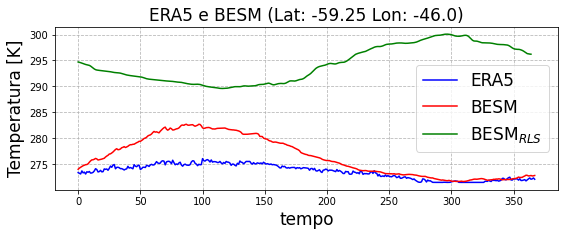

In [50]:
plt.figure(figsize=(9, 3))
plt.grid(alpha=0.9, linestyle='--')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3],color="green",label='BESM$_{RLS}$'),plt.legend(fontsize=17)

plt.xlabel("tempo",fontsize=17)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

# (12). Métodos concorrentes (MC):
\begin{equation}
    \hat{x}(n) = ( x(n) - \mu_X) \frac{\sigma_D}{\sigma_X}+ \mu_D. \label{eq:adjust_mean_var}
\end{equation}

$$ x(n): Ajuste \; (2007-2008-2009-2010) $$
$$ \sigma_X, \sigma_D,\mu_X, \mu_D: Treinamento \; (2006) $$

## (12.1) MC no domínio do tempo:

In [51]:
def MC_pra_Temp(serie_era,serie_besm,SERIE_ajst):
    Z = []
    for F in range(0,SERIE_ajst.shape[1]):
        for CF in range(0,SERIE_ajst.shape[2]):
            Z.append((SERIE_ajst[:,F,CF]-np.mean(serie_besm[:,F,CF]))*(np.nanvar(serie_era[:,F,CF])/np.nanvar(serie_besm[:,F,CF])) + np.mean(serie_era[:,F,CF]))
    return(np.asarray(Z))

In [52]:
def BLOQUES_MC_TEMP(E6_Bloques,B6_Bloques,B7_Bloques):
    Z = []
    W = []
    for i in range(E6_Bloques.shape[0]):
        Z.append(MC_pra_Temp(E6_Bloques[i],B6_Bloques[i],B7_Bloques[i]))
    np.asarray(Z)
    for c in range(E6_Bloques.shape[0]):
        W.append(Z[c].reshape(E6_Bloques.shape[2],E6_Bloques.shape[2],E6_Bloques.shape[1]))#medidas das caixas (8,8,368),(16,16,368),(32,32,368)
    return(np.asarray(W))

In [53]:
B7_Bq_MC_temp = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6,caixa_coor_FIXA_besm_6,caixa_coor_FIXA_besm_7)
B7_Bq_MC_temp.shape

(2, 32, 32, 368)

## (12.2) MC no domínio da frequência:

In [54]:
def MC_pra_Freq(serie_era,serie_besm,SERIE_ajst):
    Z = []
    for F in range(0,SERIE_ajst.shape[0]):
        for CF in range(0,SERIE_ajst.shape[1]):
            Z.append((SERIE_ajst[F,CF,:]-np.mean(serie_besm[F,CF,:]))*(np.nanvar(serie_era[F,CF,:])/np.nanvar(serie_besm[F,CF,:])) + np.mean(serie_era[F,CF,:]))
    return(np.asarray(Z))

In [55]:
def BLOQUES_MC_FREQ(E6_Bloques,B6_Bloques,B7_Bloques):
    Z = []
    W = []
    for i in range(E6_Bloques.shape[0]):
        Z.append(MC_pra_Freq(E6_Bloques[i],B6_Bloques[i],B7_Bloques[i]))
    np.asarray(Z)
    for c in range(E6_Bloques.shape[0]):
        W.append(Z[c].reshape(E6_Bloques.shape[1],E6_Bloques.shape[1],E6_Bloques.shape[3])) #medidas das caixas (8,8,368),(16,16,368),(32,32,368)
    return(np.asarray(W))

In [56]:
B7_Bq_MC_freq = BLOQUES_MC_FREQ(E6_Bq_1rasComp,B6_Bq_1rasComp,B7_Bq_1rasComp)
B7_Bq_MC_freq.shape

(2, 32, 32, 368)

In [57]:
def IDCT_MC_FREQ(M):
    Z = []
    for i in range(0,M.shape[2]):
        Z.append(idct2(M[:,:,i]))
    return(np.asarray(Z))

def BLOQUES_IDCT_MC_FREQ(B):
    W = []
    for i in range(B.shape[0]):
        W.append(IDCT_MC_FREQ(B[i]))
    return(np.asarray(W))

In [58]:
B7_Bq_MC_freq_idct = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq)
B7_Bq_MC_freq_idct.shape

(2, 368, 32, 32)

## (12.3) RLS no domínio do tempo:

In [59]:
def entradas_x1_RLS(M,N_r,p,f):
    Z = []
    for i in range(0,M.shape[2]):
        Z.append(pa.input_from_history(Serie_rep(M[:,f,i], N_r),p))
    return(np.asarray(Z))

def entradas_x2_RLS(M):
    Z = []
    for i in range(M.shape[1]):
        Z.append(entradas_x1_RLS(M,N_r,p,i))
    return(np.asarray(Z))

In [60]:
def ENTRADA_BLOQUES_RLS(B):
    Z = []
    for i in range(B.shape[0]):
        Z.append(entradas_x2_RLS(B[i]))
    return(np.asarray(Z))

In [61]:
def desejada_x1_RLS(M,f,N_r):
    Z = []
    for i in range(0,M.shape[2]):
        Z.append(Serie_rep(M[:,f,i], N_r))
    return(np.asarray(Z))

def desejada_x2_RLS(M):
    Z = []
    for i in range(0,M.shape[1]):
        Z.append(desejada_x1_RLS(M,i,N_r))
    return(np.asarray(Z))

In [62]:
def DESEADO_BLOQUES_RLS(B):
    Z = []
    for i in range(B.shape[0]):
        Z.append(desejada_x2_RLS(B[i]))
    return(np.asarray(Z))

- Entradas (BESM):

In [63]:
B6_Bq_entrada_RLS_temp = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6)
B7_Bq_entrada_RLS_temp = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7) 
B6_Bq_entrada_RLS_temp.shape 

(2, 32, 32, 733, 4)

- Salidas (ERA5):

In [64]:
E6_Bq_deseada_RLS_temp = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6)
E7_Bq_deseada_RLS_temp = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7)
E6_Bq_deseada_RLS_temp.shape 

(2, 32, 32, 736)

- Filtro RLS no tempo para os Bloques:

In [65]:
B6_Bq_fRLS_RLS_temp = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp, E6_Bq_deseada_RLS_temp)
len(B6_Bq_fRLS_RLS_temp)

2

In [66]:
def CONVOLUÇÃO_1_RLS_temp(M_dct_ajuste,W,f):
    Z = []
    for i in range(0,M_dct_ajuste.shape[2]):
        Z.append(Filtro_FIR(M_dct_ajuste[:,f,i],W[f][i][2][-1])) 
    return(np.asarray(Z))   

def CONVOLUÇÃO_2_RLS_temp(M_dct_ajuste,W):
    Z = []
    for i in range(0,M_dct_ajuste.shape[1]):
        Z.append(CONVOLUÇÃO_1_RLS_temp(M_dct_ajuste,W,i))
    return(np.asarray(Z))

def BLOQUES_CONVOLUÇÃO_RLS_temp(B,W):
    Z = []
    for i in range(B.shape[0]):
        Z.append(CONVOLUÇÃO_2_RLS_temp(B[i],W[i]))
    return(np.asarray(Z))

In [67]:
B7_Bq_conv_RLS_temp = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7,B6_Bq_fRLS_RLS_temp)
B7_Bq_conv_RLS_temp.shape

(2, 32, 32, 365)

# (13). Grafico dos 4 métodos:

In [68]:
B7_Bq_MC_freq_idct.shape

(2, 368, 32, 32)

Text(0.5, 1.0, 'ERA5 e BESM Anual (Lat: -59.25 Lon: -46.0)')

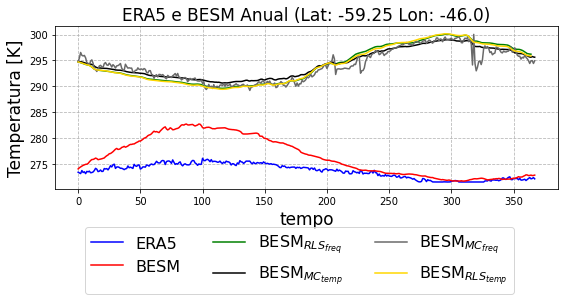

In [69]:
plt.figure(figsize=(9, 3))
plt.grid(alpha=0.9, linestyle='--')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
#Shape: (3, 365, 8, 8)
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$'),plt.legend(fontsize=17)
#Shape: (3, 8, 8, 368)
plt.plot(B7_Bq_MC_temp[Bloque_i][3,3,:],color="black",label='BESM$_{MC_{temp}}$'),plt.legend(fontsize=17)
#Shape: (3, 368, 8, 8)
plt.plot(B7_Bq_MC_freq_idct[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$'),plt.legend(fontsize=17)
#Shape: (3, 8, 8, 365)
plt.plot(B7_Bq_conv_RLS_temp[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$'),plt.legend(fontsize=17)

plt.legend(loc=1,fontsize=16)
#plt.text(40,-5.2,"dias", fontsize=16)
#plt.text(160,-2.8,"dias", fontsize=16)
plt.legend(bbox_to_anchor =(0.93, -0.18), ncol = 3, fontsize=16)

#plt.ylim(min(coorde_BLOQUE_aleat_B7[:,3,3])-1,max(coorde_BLOQUE_aleat_B7[:,3,3]))

plt.xlabel("tempo",fontsize=17)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

# (14). Funciones para indentificar métodos mejores y peores:

In [70]:
B7_Bq_conv_idct.shape, B7_Bq_conv_RLS_temp.shape, B7_Bq_MC_freq_idct.shape, B7_Bq_MC_temp.shape

((2, 365, 32, 32), (2, 32, 32, 365), (2, 368, 32, 32), (2, 32, 32, 368))

In [71]:
caixa_coor_FIXA_besm_7.shape,caixa_coor_FIXA_era_7.shape

((2, 368, 32, 32), (2, 368, 32, 32))

In [72]:
D_0 = -3 #dias que se resta de lo adicionado, para MC_temp, MC_freq y Iniciales
def BLOQUES_METODOS(RLS_freq, RLS_temp, MC_freq, MC_temp, BESM_inic, ERA_inic): 
    erro_inic = []
    RLS_freq_inic = []
    RLS_temp_inic = []
    MC_freq_inic = []
    MC_temp_inic = []
    for i in range(BESM_inic.shape[0]):
        erro_inic.append(BESM_inic[i][:D_0,3,3]-ERA_inic[i][:D_0,3,3])
        RLS_freq_inic.append(RLS_freq[i][:,3,3]-ERA_inic[i][:D_0,3,3])
        RLS_temp_inic.append(RLS_temp[i][3,3,:]-ERA_inic[i][:D_0,3,3])
        MC_freq_inic.append(MC_freq[i][:D_0,3,3]-ERA_inic[i][:D_0,3,3])
        MC_temp_inic.append(MC_temp[i][3,3,:D_0]-ERA_inic[i][:D_0,3,3])
    erro_inic_mse = []
    RLS_freq_inic_mse = []
    RLS_temp_inic_mse = []
    MC_freq_inic_mse = []
    MC_temp_inic_mse = []
    for x in range(BESM_inic.shape[0]):
        erro_inic_mse.append(np.mean((np.asarray(erro_inic)**2)[x], axis=0))
        RLS_freq_inic_mse.append(np.mean((np.asarray(RLS_freq_inic)**2)[x], axis=0))
        RLS_temp_inic_mse.append(np.mean((np.asarray(RLS_temp_inic)**2)[x], axis=0))
        MC_freq_inic_mse.append(np.mean((np.asarray(MC_freq_inic)**2)[x], axis=0))
        MC_temp_inic_mse.append(np.mean((np.asarray(MC_temp_inic)**2)[x], axis=0))
    erro_inic_mae = []
    RLS_freq_inic_mae = []
    RLS_temp_inic_mae = []
    MC_freq_inic_mae = []
    MC_temp_inic_mae = []
    for y in range(BESM_inic.shape[0]):
        erro_inic_mae.append(np.max(abs(np.asarray(erro_inic)[y])))
        RLS_freq_inic_mae.append(np.max(abs(np.asarray(RLS_freq_inic)[y])))
        RLS_temp_inic_mae.append(np.max(abs(np.asarray(RLS_temp_inic)[y])))
        MC_freq_inic_mae.append(np.max(abs(np.asarray(MC_freq_inic)[y])))
        MC_temp_inic_mae.append(np.max(abs(np.asarray(MC_temp_inic)[y])))
    erro_inic_pmae = []
    RLS_freq_inic_pmae = []
    RLS_temp_inic_pmae = []
    MC_freq_inic_pmae = []
    MC_temp_inic_pmae = []
    for z in range(BESM_inic.shape[0]):
        erro_inic_pmae.append(100*np.max(abs(np.asarray(erro_inic)[z]/ERA_inic[z][:D_0,3,3])))
        RLS_freq_inic_pmae.append(100*np.max(abs(np.asarray(RLS_freq_inic)[z]/ERA_inic[z][:D_0,3,3])))
        RLS_temp_inic_pmae.append(100*np.max(abs(np.asarray(RLS_temp_inic)[z]/ERA_inic[z][:D_0,3,3])))
        MC_freq_inic_pmae.append(100*np.max(abs(np.asarray(MC_freq_inic)[z]/ERA_inic[z][:D_0,3,3])))
        MC_temp_inic_pmae.append(100*np.max(abs(np.asarray(MC_temp_inic)[z]/ERA_inic[z][:D_0,3,3])))
        
    return(np.asarray(erro_inic), np.asarray(RLS_freq_inic), np.asarray(RLS_temp_inic),
          np.asarray(MC_freq_inic), np.asarray(MC_temp_inic),
        np.asarray(erro_inic_mse), np.asarray(RLS_freq_inic_mse), np.asarray(RLS_temp_inic_mse),
          np.asarray(MC_freq_inic_mse), np.asarray(MC_temp_inic_mse),
           np.asarray(erro_inic_mae), np.asarray(RLS_freq_inic_mae), np.asarray(RLS_temp_inic_mae),
          np.asarray(MC_freq_inic_mae), np.asarray(MC_temp_inic_mae),
        np.asarray(erro_inic_pmae), np.asarray(RLS_freq_inic_pmae), np.asarray(RLS_temp_inic_pmae),
          np.asarray(MC_freq_inic_pmae), np.asarray(MC_temp_inic_pmae))

In [73]:
a1 = BLOQUES_METODOS(B7_Bq_conv_idct,B7_Bq_conv_RLS_temp,B7_Bq_MC_freq_idct,
                     B7_Bq_MC_temp,caixa_coor_FIXA_besm_7,caixa_coor_FIXA_era_7)
len(a1), a1[0].shape

(20, (2, 365))

# (15). Designar si es mayor o menor a los datos inciales:

In [74]:
def MAYOR_MENOR_METODOS_MSE(M):
    Z_mse = M[5:10]
    Z_mse_m = []
    Z_mse_b = []
    for i in range(len(Z_mse)-1):
        for c in range(Z_mse[0].shape[0]):
            if (Z_mse[0][c] >= Z_mse[i+1][c]):
                Z_mse_b.append(i)
            if (Z_mse[0][c] < Z_mse[i+1][c]):
                Z_mse_m.append(i)
    Numeros_MET_m, T_contados_malos = np.unique(np.asarray(Z_mse_m), return_counts=True)
    Numeros_MET_b, T_contados_buenos = np.unique(np.asarray(Z_mse_b), return_counts=True)
    MET_y_CONTADO_malos = np.asarray([Numeros_MET_m,T_contados_malos])
    MET_y_CONTADO_bueno = np.asarray([Numeros_MET_b,T_contados_buenos])
    return(MET_y_CONTADO_malos, MET_y_CONTADO_bueno)

def MAYOR_MENOR_METODOS_MAE(M):
    Z_mse = M[10:15]
    Z_mse_m = []
    Z_mse_b = []
    for i in range(len(Z_mse)-1):
        for c in range(Z_mse[0].shape[0]):
            if (Z_mse[0][c] >= Z_mse[i+1][c]):
                Z_mse_b.append(i)
            if (Z_mse[0][c] < Z_mse[i+1][c]):
                Z_mse_m.append(i)
    Numeros_MET_m, T_contados_malos = np.unique(np.asarray(Z_mse_m), return_counts=True)
    Numeros_MET_b, T_contados_buenos = np.unique(np.asarray(Z_mse_b), return_counts=True)
    MET_y_CONTADO_malos = np.asarray([Numeros_MET_m,T_contados_malos])
    MET_y_CONTADO_bueno = np.asarray([Numeros_MET_b,T_contados_buenos])
    return(MET_y_CONTADO_malos, MET_y_CONTADO_bueno)

def MAYOR_MENOR_METODOS_PMAE(M):
    Z_mse = M[15:20]
    Z_mse_m = []
    Z_mse_b = []
    for i in range(len(Z_mse)-1):
        for c in range(Z_mse[0].shape[0]):
            if (Z_mse[0][c] >= Z_mse[i+1][c]):
                Z_mse_b.append(i)
            if (Z_mse[0][c] < Z_mse[i+1][c]):
                Z_mse_m.append(i)
    Numeros_MET_m, T_contados_malos = np.unique(np.asarray(Z_mse_m), return_counts=True)
    Numeros_MET_b, T_contados_buenos = np.unique(np.asarray(Z_mse_b), return_counts=True)
    MET_y_CONTADO_malos = np.asarray([Numeros_MET_m,T_contados_malos])
    MET_y_CONTADO_bueno = np.asarray([Numeros_MET_b,T_contados_buenos])
    return(np.asarray(MET_y_CONTADO_malos), np.asarray(MET_y_CONTADO_bueno))
#    RLS_freq...0
#    RLS_temp...1
#    MC_freq....2
#    MC_temp....3

In [75]:
p_mse = MAYOR_MENOR_METODOS_MSE(a1)
p_mse, p_mse[0].shape, p_mse[0][1]

((array([[1, 2],
         [1, 1]]),
  array([[0, 1, 2, 3],
         [2, 1, 1, 2]])),
 (2, 2),
 array([1, 1]))

In [76]:
p_mae = MAYOR_MENOR_METODOS_MAE(a1)
p_mae

(array([[1, 2],
        [1, 2]]),
 array([[0, 1, 3],
        [2, 1, 2]]))

In [77]:
p_pmae = MAYOR_MENOR_METODOS_PMAE(a1)
p_pmae

(array([[1, 2],
        [1, 2]]),
 array([[0, 1, 3],
        [2, 1, 2]]))

## Graficas automatizadas:

In [78]:
filters = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse[0][0], "pior_1": p_mse[0][1], "melhor_0": p_mse[1][0], "melhor_1": p_mse[1][1], "plot_position": 311},
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae[0][0], "pior_1": p_mae[0][1], "melhor_0": p_mae[1][0], "melhor_1": p_mae[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae[0][0], "pior_1": p_pmae[0][1], "melhor_0": p_pmae[1][0], "melhor_1": p_pmae[1][1],"plot_position": 313 },
]

# (01). CORTANDO PARA ESTACIONES: 
# ...Nov-Dic-En...

In [79]:
Es1,Es2 = 0,95
caixa_coor_FIXA_besm_6_NDE = Caixas_besm_era[0][:,Es1:Es2,:,:]
caixa_coor_FIXA_era_6_NDE = Caixas_besm_era[1][:,Es1:Es2,:,:]
caixa_coor_FIXA_besm_7_NDE = Caixas_besm_era[2][:,Es1:Es2,:,:]
caixa_coor_FIXA_era_7_NDE = Caixas_besm_era[3][:,Es1:Es2,:,:]

caixa_coor_FIXA_besm_6_NDE.shape,caixa_coor_FIXA_besm_7_NDE.shape,caixa_coor_FIXA_era_7_NDE.shape,caixa_coor_FIXA_era_6_NDE.shape

((2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32))

In [80]:
#Calculo das DCTs:
dct_E6_Bq_NDE = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_NDE)
dct_B6_Bq_NDE = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_NDE) 
dct_E7_Bq_NDE = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_NDE) 
dct_B7_Bq_NDE = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_NDE)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_NDE = COMP1_DAS_DCTS(dct_E6_Bq_NDE) 
B6_Bq_1rasComp_NDE = COMP1_DAS_DCTS(dct_B6_Bq_NDE)
E7_Bq_1rasComp_NDE = COMP1_DAS_DCTS(dct_E7_Bq_NDE)
B7_Bq_1rasComp_NDE = COMP1_DAS_DCTS(dct_B7_Bq_NDE)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_NDE = ENTRADA_BLOQUES(B6_Bq_1rasComp_NDE)
B7_Bq_entrada_NDE = ENTRADA_BLOQUES(B7_Bq_1rasComp_NDE)

E6_Bq_deseada_NDE = DESEADO_BLOQUES(E6_Bq_1rasComp_NDE)
E7_Bq_deseada_NDE = DESEADO_BLOQUES(E7_Bq_1rasComp_NDE)
#Filtro adaptativo RLS:
B6_Bq_fRLS_NDE = FILTROS_BLOQUES(B6_Bq_entrada_NDE, E6_Bq_deseada_NDE)
#Filtro FIR (Convolução):
B7_Bq_conv_NDE = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_NDE,B6_Bq_fRLS_NDE)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_NDE = BLOQUES_IDCT(B7_Bq_conv_NDE)

In [81]:
#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_NDE = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_NDE,caixa_coor_FIXA_besm_6_NDE,caixa_coor_FIXA_besm_7_NDE)
#MC no domínio da frequência:
B7_Bq_MC_freq_NDE = BLOQUES_MC_FREQ(E6_Bq_1rasComp_NDE,B6_Bq_1rasComp_NDE,B7_Bq_1rasComp_NDE)
B7_Bq_MC_freq_idct_NDE = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_NDE)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_NDE = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_NDE)
B7_Bq_entrada_RLS_temp_NDE = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_NDE) 

E6_Bq_deseada_RLS_temp_NDE = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_NDE)
E7_Bq_deseada_RLS_temp_NDE = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_NDE)

B6_Bq_fRLS_RLS_temp_NDE = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_NDE, E6_Bq_deseada_RLS_temp_NDE)
B7_Bq_conv_RLS_temp_NDE = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_NDE,B6_Bq_fRLS_RLS_temp_NDE)

B7_Bq_MC_temp_NDE.shape, B7_Bq_MC_freq_idct_NDE.shape

((2, 32, 32, 95), (2, 95, 32, 32))

# (02). CORTANDO PARA ESTACIONES: 

# ...Feb-Mar-Abr...

In [82]:
Es3,Es4 = 92,184
caixa_coor_FIXA_besm_6_FMA = Caixas_besm_era[0][:,Es3:Es4,:,:]
caixa_coor_FIXA_era_6_FMA = Caixas_besm_era[1][:,Es3:Es4,:,:]
caixa_coor_FIXA_besm_7_FMA = Caixas_besm_era[2][:,Es3:Es4,:,:]
caixa_coor_FIXA_era_7_FMA = Caixas_besm_era[3][:,Es3:Es4,:,:]

caixa_coor_FIXA_besm_6_FMA.shape,caixa_coor_FIXA_besm_7_FMA.shape,caixa_coor_FIXA_era_7_FMA.shape,caixa_coor_FIXA_era_6_FMA.shape

((2, 92, 32, 32), (2, 92, 32, 32), (2, 92, 32, 32), (2, 92, 32, 32))

In [83]:
#Calculo das DCTs:
dct_E6_Bq_FMA = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_FMA)
dct_B6_Bq_FMA = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_FMA) 
dct_E7_Bq_FMA = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_FMA) 
dct_B7_Bq_FMA = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_FMA)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_FMA = COMP1_DAS_DCTS(dct_E6_Bq_FMA) 
B6_Bq_1rasComp_FMA = COMP1_DAS_DCTS(dct_B6_Bq_FMA)
E7_Bq_1rasComp_FMA = COMP1_DAS_DCTS(dct_E7_Bq_FMA)
B7_Bq_1rasComp_FMA = COMP1_DAS_DCTS(dct_B7_Bq_FMA)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_FMA = ENTRADA_BLOQUES(B6_Bq_1rasComp_FMA)
B7_Bq_entrada_FMA = ENTRADA_BLOQUES(B7_Bq_1rasComp_FMA)

E6_Bq_deseada_FMA = DESEADO_BLOQUES(E6_Bq_1rasComp_FMA)
E7_Bq_deseada_FMA = DESEADO_BLOQUES(E7_Bq_1rasComp_FMA)
#Filtro adaptativo RLS:
B6_Bq_fRLS_FMA = FILTROS_BLOQUES(B6_Bq_entrada_FMA, E6_Bq_deseada_FMA)
#Filtro FIR (Convolução):
B7_Bq_conv_FMA = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_FMA,B6_Bq_fRLS_FMA)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_FMA = BLOQUES_IDCT(B7_Bq_conv_FMA)

In [84]:
#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_FMA = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_FMA,caixa_coor_FIXA_besm_6_FMA,caixa_coor_FIXA_besm_7_FMA)
#MC no domínio da frequência:
B7_Bq_MC_freq_FMA = BLOQUES_MC_FREQ(E6_Bq_1rasComp_FMA,B6_Bq_1rasComp_FMA,B7_Bq_1rasComp_FMA)
B7_Bq_MC_freq_idct_FMA = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_FMA)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_FMA = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_FMA)
B7_Bq_entrada_RLS_temp_FMA = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_FMA) 

E6_Bq_deseada_RLS_temp_FMA = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_FMA)
E7_Bq_deseada_RLS_temp_FMA = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_FMA)

B6_Bq_fRLS_RLS_temp_FMA = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_FMA, E6_Bq_deseada_RLS_temp_FMA)
B7_Bq_conv_RLS_temp_FMA = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_FMA,B6_Bq_fRLS_RLS_temp_FMA)

# (03). CORTANDO PARA ESTACIONES: 

# ...May-Jun-Jul...

In [85]:
Es5,Es6 = 181,276
caixa_coor_FIXA_besm_6_MJJ = Caixas_besm_era[0][:,Es5:Es6,:,:]
caixa_coor_FIXA_era_6_MJJ = Caixas_besm_era[1][:,Es5:Es6,:,:]
caixa_coor_FIXA_besm_7_MJJ = Caixas_besm_era[2][:,Es5:Es6,:,:]
caixa_coor_FIXA_era_7_MJJ = Caixas_besm_era[3][:,Es5:Es6,:,:]

caixa_coor_FIXA_besm_6_MJJ.shape,caixa_coor_FIXA_besm_7_MJJ.shape,caixa_coor_FIXA_era_7_MJJ.shape,caixa_coor_FIXA_era_6_MJJ.shape

((2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32))

In [86]:
#Calculo das DCTs:
dct_E6_Bq_MJJ = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_MJJ)
dct_B6_Bq_MJJ = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_MJJ) 
dct_E7_Bq_MJJ = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_MJJ) 
dct_B7_Bq_MJJ = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_MJJ)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_MJJ = COMP1_DAS_DCTS(dct_E6_Bq_MJJ) 
B6_Bq_1rasComp_MJJ = COMP1_DAS_DCTS(dct_B6_Bq_MJJ)
E7_Bq_1rasComp_MJJ = COMP1_DAS_DCTS(dct_E7_Bq_MJJ)
B7_Bq_1rasComp_MJJ = COMP1_DAS_DCTS(dct_B7_Bq_MJJ)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_MJJ = ENTRADA_BLOQUES(B6_Bq_1rasComp_MJJ)
B7_Bq_entrada_MJJ = ENTRADA_BLOQUES(B7_Bq_1rasComp_MJJ)

E6_Bq_deseada_MJJ = DESEADO_BLOQUES(E6_Bq_1rasComp_MJJ)
E7_Bq_deseada_MJJ = DESEADO_BLOQUES(E7_Bq_1rasComp_MJJ)
#Filtro adaptativo RLS:
B6_Bq_fRLS_MJJ = FILTROS_BLOQUES(B6_Bq_entrada_MJJ, E6_Bq_deseada_MJJ)
#Filtro FIR (Convolução):
B7_Bq_conv_MJJ = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_MJJ,B6_Bq_fRLS_MJJ)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_MJJ = BLOQUES_IDCT(B7_Bq_conv_MJJ)

In [87]:
#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_MJJ = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_MJJ,caixa_coor_FIXA_besm_6_MJJ,caixa_coor_FIXA_besm_7_MJJ)
#MC no domínio da frequência:
B7_Bq_MC_freq_MJJ = BLOQUES_MC_FREQ(E6_Bq_1rasComp_MJJ,B6_Bq_1rasComp_MJJ,B7_Bq_1rasComp_MJJ)
B7_Bq_MC_freq_idct_MJJ = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_MJJ)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_MJJ = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_MJJ)
B7_Bq_entrada_RLS_temp_MJJ = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_MJJ) 

E6_Bq_deseada_RLS_temp_MJJ = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_MJJ)
E7_Bq_deseada_RLS_temp_MJJ = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_MJJ)

B6_Bq_fRLS_RLS_temp_MJJ = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_MJJ, E6_Bq_deseada_RLS_temp_MJJ)
B7_Bq_conv_RLS_temp_MJJ = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_MJJ,B6_Bq_fRLS_RLS_temp_MJJ)

# (04). CORTANDO PARA ESTACIONES: 

# ...Ags-Set-Oct...

In [88]:
Es7,Es8 = 273,368
caixa_coor_FIXA_besm_6_ASO = Caixas_besm_era[0][:,Es7:Es8,:,:]
caixa_coor_FIXA_era_6_ASO = Caixas_besm_era[1][:,Es7:Es8,:,:]
caixa_coor_FIXA_besm_7_ASO = Caixas_besm_era[2][:,Es7:Es8,:,:]
caixa_coor_FIXA_era_7_ASO = Caixas_besm_era[3][:,Es7:Es8,:,:]

caixa_coor_FIXA_besm_6_ASO.shape,caixa_coor_FIXA_besm_7_ASO.shape,caixa_coor_FIXA_era_7_ASO.shape,caixa_coor_FIXA_era_6_ASO.shape

((2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32), (2, 95, 32, 32))

In [89]:
#Calculo das DCTs:
dct_E6_Bq_ASO = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_ASO)
dct_B6_Bq_ASO = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_ASO) 
dct_E7_Bq_ASO = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_ASO) 
dct_B7_Bq_ASO = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_ASO)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_ASO = COMP1_DAS_DCTS(dct_E6_Bq_ASO) 
B6_Bq_1rasComp_ASO = COMP1_DAS_DCTS(dct_B6_Bq_ASO)
E7_Bq_1rasComp_ASO = COMP1_DAS_DCTS(dct_E7_Bq_ASO)
B7_Bq_1rasComp_ASO = COMP1_DAS_DCTS(dct_B7_Bq_ASO)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_ASO = ENTRADA_BLOQUES(B6_Bq_1rasComp_ASO)
B7_Bq_entrada_ASO = ENTRADA_BLOQUES(B7_Bq_1rasComp_ASO)

E6_Bq_deseada_ASO = DESEADO_BLOQUES(E6_Bq_1rasComp_ASO)
E7_Bq_deseada_ASO = DESEADO_BLOQUES(E7_Bq_1rasComp_ASO)
#Filtro adaptativo RLS:
B6_Bq_fRLS_ASO = FILTROS_BLOQUES(B6_Bq_entrada_ASO, E6_Bq_deseada_ASO)
#Filtro FIR (Convolução):
B7_Bq_conv_ASO = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_ASO,B6_Bq_fRLS_ASO)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_ASO = BLOQUES_IDCT(B7_Bq_conv_ASO)

In [90]:
#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_ASO = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_ASO,caixa_coor_FIXA_besm_6_ASO,caixa_coor_FIXA_besm_7_ASO)
#MC no domínio da frequência:
B7_Bq_MC_freq_ASO = BLOQUES_MC_FREQ(E6_Bq_1rasComp_ASO,B6_Bq_1rasComp_ASO,B7_Bq_1rasComp_ASO)
B7_Bq_MC_freq_idct_ASO = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_ASO)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_ASO = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_ASO)
B7_Bq_entrada_RLS_temp_ASO = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_ASO) 

E6_Bq_deseada_RLS_temp_ASO = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_ASO)
E7_Bq_deseada_RLS_temp_ASO = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_ASO)

B6_Bq_fRLS_RLS_temp_ASO = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_ASO, E6_Bq_deseada_RLS_temp_ASO)
B7_Bq_conv_RLS_temp_ASO = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_ASO,B6_Bq_fRLS_RLS_temp_ASO)

#### Recortando los dias aumentados: (MC_temp y MC_freq)

In [91]:
B7_Bq_conv_idct_ASO.shape,B7_Bq_MC_temp_ASO.shape,B7_Bq_MC_freq_idct_ASO.shape,B7_Bq_conv_RLS_temp_ASO.shape

((2, 92, 32, 32), (2, 32, 32, 95), (2, 95, 32, 32), (2, 32, 32, 92))

# (05). CONCATENANDO ESTACIONES:

In [92]:
#Aqui sólo corregimos el orden de su Shape de RLS_temp, para luego concatenar.
def CORREGIR_RLS_TEMP_01(M):
    Z = []
    for i in range(M.shape[3]):
        Z.append(M[:,:,:,i])
    return(np.asarray(Z))

def CORREGIR_RLS_TEMP_02(M):
    Z = []
    for i in range(M.shape[1]):
        Z.append(M[:,i,:,:])
    return(np.asarray(Z))

In [93]:
B7_Bq_conv_RLS_temp_NDE.shape

(2, 32, 32, 92)

In [94]:
NDE_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_NDE)
NDE_2 = CORREGIR_RLS_TEMP_02(NDE_1)
FMA_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_FMA)
FMA_2 = CORREGIR_RLS_TEMP_02(FMA_1)
MJJ_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_MJJ)
MJJ_2 = CORREGIR_RLS_TEMP_02(MJJ_1)
ASO_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_ASO)
ASO_2 = CORREGIR_RLS_TEMP_02(ASO_1)
ASO_1.shape, ASO_2.shape

((92, 2, 32, 32), (2, 92, 32, 32))

In [95]:
#Aqui estamos corrigiendo MC_temp com RLS_temp porque sus SHAPES coinciden
NDE_1_MC_temp = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_NDE)
NDE_2_MC_temp  = CORREGIR_RLS_TEMP_02(NDE_1_MC_temp)
FMA_1_MC_temp  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_FMA)
FMA_2_MC_temp  = CORREGIR_RLS_TEMP_02(FMA_1_MC_temp)
MJJ_1_MC_temp  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_MJJ)
MJJ_2_MC_temp  = CORREGIR_RLS_TEMP_02(MJJ_1_MC_temp)
ASO_1_MC_temp  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_ASO)
ASO_2_MC_temp  = CORREGIR_RLS_TEMP_02(ASO_1_MC_temp)
ASO_1_MC_temp .shape, ASO_2_MC_temp .shape

((95, 2, 32, 32), (2, 95, 32, 32))

In [96]:
B7_Bq_conv_idct_UNIDO=np.concatenate((B7_Bq_conv_idct_NDE,B7_Bq_conv_idct_FMA,B7_Bq_conv_idct_MJJ,B7_Bq_conv_idct_ASO),axis=1)
B7_Bq_MC_temp_UNIDO= np.concatenate((NDE_2_MC_temp[:,0:-3,:,:],FMA_2_MC_temp[:,0:-3,:,:],MJJ_2_MC_temp[:,0:-3,:,:],ASO_2_MC_temp[:,0:-3,:,:]),axis=1)
B7_Bq_MC_freq_idct_UNIDO= np.concatenate((B7_Bq_MC_freq_idct_NDE[:,0:-3,:,:],B7_Bq_MC_freq_idct_FMA[:,0:-3,:,:],B7_Bq_MC_freq_idct_MJJ[:,0:-3,:,:],B7_Bq_MC_freq_idct_ASO[:,0:-3,:,:]),axis=1)
B7_Bq_conv_RLS_temp_UNIDO= np.concatenate((NDE_2,FMA_2,MJJ_2,ASO_2),axis=1)

In [97]:
B7_Bq_conv_idct_UNIDO.shape, B7_Bq_MC_temp_UNIDO.shape, B7_Bq_MC_freq_idct_UNIDO.shape, B7_Bq_conv_RLS_temp_UNIDO.shape

((2, 365, 32, 32), (2, 365, 32, 32), (2, 365, 32, 32), (2, 365, 32, 32))

Text(0.5, 1.0, 'ERA5 e BESM Anual (concatenado) (Lat: -59.25 Lon: -46.0)')

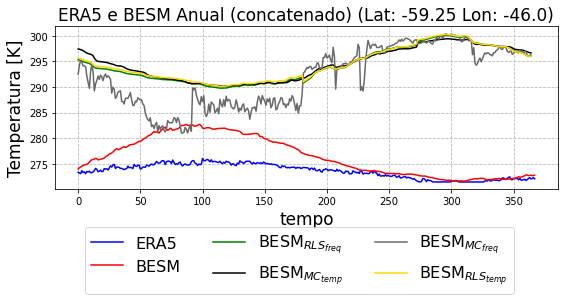

In [98]:
plt.figure(figsize=(9, 3))
plt.grid(alpha=0.9, linestyle='--')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM'),plt.legend(fontsize=17)

plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$'),plt.legend(fontsize=17)

plt.plot(B7_Bq_MC_temp_UNIDO[Bloque_i][:,3,3],color="black",label='BESM$_{MC_{temp}}$'),plt.legend(fontsize=17)

plt.plot(B7_Bq_MC_freq_idct_UNIDO[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$'),plt.legend(fontsize=17)
#...Este es el unico que cambio
plt.plot(B7_Bq_conv_RLS_temp_UNIDO[Bloque_i][:,3,3],color="gold",label='BESM$_{RLS_{temp}}$'),plt.legend(fontsize=17)

plt.legend(loc=1,fontsize=16)
#plt.text(40,-5.2,"dias", fontsize=16)
#plt.text(160,-2.8,"dias", fontsize=16)
plt.legend(bbox_to_anchor =(0.93, -0.18), ncol = 3, fontsize=16)
plt.xlabel("tempo",fontsize=17)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM Anual (concatenado) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
#plt.ylim(min(coorde_BLOQUE_aleat_B7[:,3,3])-1,max(coorde_BLOQUE_aleat_B7[:,3,3]))


# (06). Designando Peores & Mejores

In [99]:
B7_Bq_conv_idct_UNIDO.shape,B7_Bq_conv_RLS_temp_UNIDO.shape,B7_Bq_MC_freq_idct_UNIDO.shape,B7_Bq_MC_temp_UNIDO.shape

((2, 365, 32, 32), (2, 365, 32, 32), (2, 365, 32, 32), (2, 365, 32, 32))

In [100]:
caixa_coor_FIXA_besm_7.shape,caixa_coor_FIXA_era_7.shape

((2, 368, 32, 32), (2, 368, 32, 32))

In [101]:
D_0 = -3 #dias que se resta de lo adicionado, para MC_temp, MC_freq y Iniciales
def BLOQUES_METODOS_UNIDO(RLS_freq, RLS_temp, MC_freq, MC_temp, BESM_inic, ERA_inic): 
    erro_inic = []
    RLS_freq_inic = []
    RLS_temp_inic = []
    MC_freq_inic = []
    MC_temp_inic = []
    for i in range(BESM_inic.shape[0]):
        erro_inic.append(BESM_inic[i][:D_0,3,3]-ERA_inic[i][:D_0,3,3])
        RLS_freq_inic.append(RLS_freq[i][:,3,3]-ERA_inic[i][:D_0,3,3])
        RLS_temp_inic.append(RLS_temp[i][:,3,3]-ERA_inic[i][:D_0,3,3])
        MC_freq_inic.append(MC_freq[i][:,3,3]-ERA_inic[i][:D_0,3,3])
        MC_temp_inic.append(MC_temp[i][:,3,3]-ERA_inic[i][:D_0,3,3])
    erro_inic_mse = []
    RLS_freq_inic_mse = []
    RLS_temp_inic_mse = []
    MC_freq_inic_mse = []
    MC_temp_inic_mse = []
    for x in range(BESM_inic.shape[0]):
        erro_inic_mse.append(np.mean((np.asarray(erro_inic)**2)[x], axis=0))
        RLS_freq_inic_mse.append(np.mean((np.asarray(RLS_freq_inic)**2)[x], axis=0))
        RLS_temp_inic_mse.append(np.mean((np.asarray(RLS_temp_inic)**2)[x], axis=0))
        MC_freq_inic_mse.append(np.mean((np.asarray(MC_freq_inic)**2)[x], axis=0))
        MC_temp_inic_mse.append(np.mean((np.asarray(MC_temp_inic)**2)[x], axis=0))
    erro_inic_mae = []
    RLS_freq_inic_mae = []
    RLS_temp_inic_mae = []
    MC_freq_inic_mae = []
    MC_temp_inic_mae = []
    for y in range(BESM_inic.shape[0]):
        erro_inic_mae.append(np.max(abs(np.asarray(erro_inic)[y])))
        RLS_freq_inic_mae.append(np.max(abs(np.asarray(RLS_freq_inic)[y])))
        RLS_temp_inic_mae.append(np.max(abs(np.asarray(RLS_temp_inic)[y])))
        MC_freq_inic_mae.append(np.max(abs(np.asarray(MC_freq_inic)[y])))
        MC_temp_inic_mae.append(np.max(abs(np.asarray(MC_temp_inic)[y])))
    erro_inic_pmae = []
    RLS_freq_inic_pmae = []
    RLS_temp_inic_pmae = []
    MC_freq_inic_pmae = []
    MC_temp_inic_pmae = []
    for z in range(BESM_inic.shape[0]):
        erro_inic_pmae.append(100*np.max(abs(np.asarray(erro_inic)[z]/ERA_inic[z][:D_0,3,3])))
        RLS_freq_inic_pmae.append(100*np.max(abs(np.asarray(RLS_freq_inic)[z]/ERA_inic[z][:D_0,3,3])))
        RLS_temp_inic_pmae.append(100*np.max(abs(np.asarray(RLS_temp_inic)[z]/ERA_inic[z][:D_0,3,3])))
        MC_freq_inic_pmae.append(100*np.max(abs(np.asarray(MC_freq_inic)[z]/ERA_inic[z][:D_0,3,3])))
        MC_temp_inic_pmae.append(100*np.max(abs(np.asarray(MC_temp_inic)[z]/ERA_inic[z][:D_0,3,3])))
        
    return(np.asarray(erro_inic), np.asarray(RLS_freq_inic), np.asarray(RLS_temp_inic),
          np.asarray(MC_freq_inic), np.asarray(MC_temp_inic),
        np.asarray(erro_inic_mse), np.asarray(RLS_freq_inic_mse), np.asarray(RLS_temp_inic_mse),
          np.asarray(MC_freq_inic_mse), np.asarray(MC_temp_inic_mse),
           np.asarray(erro_inic_mae), np.asarray(RLS_freq_inic_mae), np.asarray(RLS_temp_inic_mae),
          np.asarray(MC_freq_inic_mae), np.asarray(MC_temp_inic_mae),
        np.asarray(erro_inic_pmae), np.asarray(RLS_freq_inic_pmae), np.asarray(RLS_temp_inic_pmae),
          np.asarray(MC_freq_inic_pmae), np.asarray(MC_temp_inic_pmae))

In [102]:
P_y_M_01 = BLOQUES_METODOS_UNIDO(B7_Bq_conv_idct_UNIDO,B7_Bq_conv_RLS_temp_UNIDO,B7_Bq_MC_freq_idct_UNIDO,
                     B7_Bq_MC_temp_UNIDO,caixa_coor_FIXA_besm_7,caixa_coor_FIXA_era_7)
len(P_y_M_01), P_y_M_01[0].shape

(20, (2, 365))

In [103]:
p_mse_UNIDO = MAYOR_MENOR_METODOS_MSE(P_y_M_01)
p_mse_UNIDO

(array([[1, 2, 3],
        [1, 2, 1]]),
 array([[0, 1, 3],
        [2, 1, 1]]))

In [104]:
p_mae_UNIDO = MAYOR_MENOR_METODOS_MAE(P_y_M_01)
p_mae_UNIDO

(array([[1, 2, 3],
        [1, 2, 1]]),
 array([[0, 1, 3],
        [2, 1, 1]]))

In [105]:
p_pmae_UNIDO = MAYOR_MENOR_METODOS_PMAE(P_y_M_01)
p_pmae_UNIDO

(array([[1, 2, 3],
        [1, 2, 1]]),
 array([[0, 1, 3],
        [2, 1, 1]]))

### Graficas Automatizadas:

In [106]:
filters_UNIDO = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse_UNIDO[0][0], "pior_1": p_mse_UNIDO[0][1], "melhor_0": p_mse_UNIDO[1][0], "melhor_1": p_mse_UNIDO[1][1], "plot_position": 311 },
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae_UNIDO[0][0], "pior_1": p_mae_UNIDO[0][1], "melhor_0": p_mae_UNIDO[1][0], "melhor_1": p_mae_UNIDO[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae_UNIDO[0][0], "pior_1": p_pmae_UNIDO[0][1], "melhor_0": p_pmae_UNIDO[1][0], "melhor_1": p_pmae_UNIDO[1][1],"plot_position": 313 },
]

# Grafico y estadisticas dos pixels:

In [107]:
T_PIXELS = caixa_coor_FIXA_besm_6.shape[0]
T_PIXELS

2

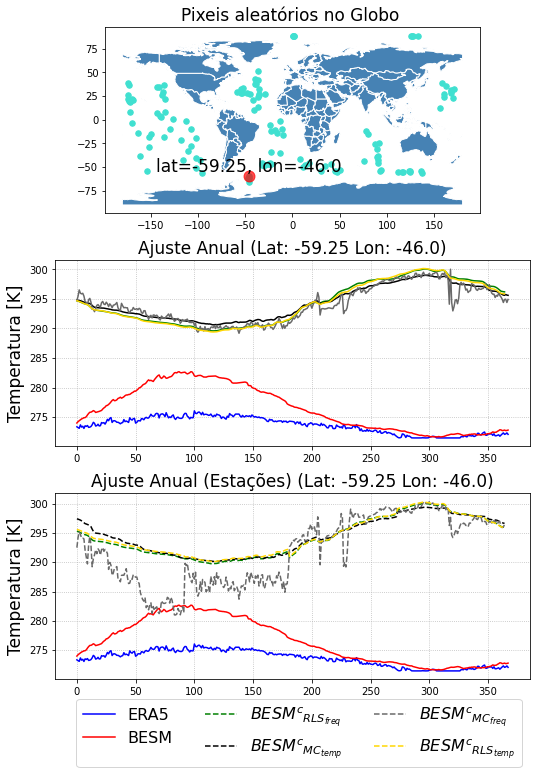

In [108]:
plt.figure(figsize=(8.5,12))
ax1 = plt.subplot(3,1,1)
world.plot(color="steelblue",edgecolor = "white",ax=ax1);
plt.scatter(puntos_coord['Longitude_1'],puntos_coord['Latitude_0'], s=30, c='turquoise', alpha=1.0)#, label='pixels analisados')
plt.scatter(coord_escogida_2['Lon'],coord_escogida_2['Lat'], s=area_2, color="red", alpha=0.7)
for i in range(len(coord_escogida_2['Lon'])):
    plt.annotate(coord_aleat_selec[i], (coord_escogida_2['Lon'][i], coord_escogida_2['Lat'][i]),
                 size=17,color="black",ha='center', va='bottom')
plt.title("Pixeis aleatórios no Globo ", size=17)

ax2 = plt.subplot(3,1,2)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp[Bloque_i][3,3,:],color="black",label='BESM$_{MC_{temp}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$')#,plt.legend(fontsize=17)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

ax3 = plt.subplot(3,1,3)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3],linestyle='--',color="green",label='$BESM^{c}$$_{RLS_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_UNIDO[Bloque_i][:,3,3],linestyle='--',color="black",label='$BESM^{c}$$_{MC_{temp}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_UNIDO[Bloque_i][:,3,3],linestyle='--',color="dimgray",label='$BESM^{c}$$_{MC_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_UNIDO[Bloque_i][:,3,3],linestyle='--',color="gold",label='$BESM^{c}$$_{RLS_{temp}}$'),plt.legend(fontsize=17)
plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(1.0, -0.06), ncol = 3, fontsize=16)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste Anual (Estações) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

plt.subplots_adjust(hspace=0.25)

# ------------------------------------------- PARA 16X16: ---------------------------------------------

In [109]:
#caixa16x16_coor_FIXA_besm_6 = Caixas_besm_era[0][:,:,:nxn16,:nxn16]
#caixa16x16_coor_FIXA_era_6 = Caixas_besm_era[1][:,:,:nxn16,:nxn16]
#caixa16x16_coor_FIXA_besm_7 = Caixas_besm_era[2][:,:,:nxn16,:nxn16]
#caixa16x16_coor_FIXA_era_7 = Caixas_besm_era[3][:,:,:nxn16,:nxn16]
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dct_E6_Bq16x16 = DCT_CAIXAS_01(caixa16x16_coor_FIXA_era_6)
dct_B6_Bq16x16 = DCT_CAIXAS_01(caixa16x16_coor_FIXA_besm_6) 
dct_E7_Bq16x16 = DCT_CAIXAS_01(caixa16x16_coor_FIXA_era_7) 
dct_B7_Bq16x16 = DCT_CAIXAS_01(caixa16x16_coor_FIXA_besm_7)

E6_Bq_1rasComp16x16 = COMP1_DAS_DCTS(dct_E6_Bq16x16) 
B6_Bq_1rasComp16x16 = COMP1_DAS_DCTS(dct_B6_Bq16x16)
E7_Bq_1rasComp16x16 = COMP1_DAS_DCTS(dct_E7_Bq16x16)
B7_Bq_1rasComp16x16 = COMP1_DAS_DCTS(dct_B7_Bq16x16)

B6_Bq_entrada16x16 = ENTRADA_BLOQUES(B6_Bq_1rasComp16x16)
B7_Bq_entrada16x16 = ENTRADA_BLOQUES(B7_Bq_1rasComp16x16) 

E6_Bq_deseada16x16 = DESEADO_BLOQUES(E6_Bq_1rasComp16x16)
E7_Bq_deseada16x16 = DESEADO_BLOQUES(E7_Bq_1rasComp16x16)

B6_Bq_fRLS16x16 = FILTROS_BLOQUES(B6_Bq_entrada16x16, E6_Bq_deseada16x16)
len(B6_Bq_fRLS16x16)

2

In [110]:
B7_Bq_conv16x16 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp16x16,B6_Bq_fRLS16x16)

B7_Bq_conv_idct16x16 = BLOQUES_IDCT(B7_Bq_conv16x16)

B7_Bq_MC_temp16x16 = BLOQUES_MC_TEMP(caixa16x16_coor_FIXA_era_6,caixa16x16_coor_FIXA_besm_6,caixa16x16_coor_FIXA_besm_7)

B7_Bq_MC_freq16x16 = BLOQUES_MC_FREQ(E6_Bq_1rasComp16x16,B6_Bq_1rasComp16x16,B7_Bq_1rasComp16x16)

B7_Bq_MC_freq_idct16x16 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq16x16)

B6_Bq_entrada_RLS_temp16x16 = ENTRADA_BLOQUES_RLS(caixa16x16_coor_FIXA_besm_6)
B7_Bq_entrada_RLS_temp16x16 = ENTRADA_BLOQUES_RLS(caixa16x16_coor_FIXA_besm_7)

E6_Bq_deseada_RLS_temp16x16 = DESEADO_BLOQUES_RLS(caixa16x16_coor_FIXA_era_6)
E7_Bq_deseada_RLS_temp16x16 = DESEADO_BLOQUES_RLS(caixa16x16_coor_FIXA_era_7)

B6_Bq_fRLS_RLS_temp16x16 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp16x16, E6_Bq_deseada_RLS_temp16x16)

B7_Bq_conv_RLS_temp16x16 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa16x16_coor_FIXA_besm_7,B6_Bq_fRLS_RLS_temp16x16)

a1_16x16 = BLOQUES_METODOS(B7_Bq_conv_idct16x16,B7_Bq_conv_RLS_temp16x16,B7_Bq_MC_freq_idct16x16,
                           B7_Bq_MC_temp16x16,caixa16x16_coor_FIXA_besm_7,caixa16x16_coor_FIXA_era_7)

p_mse16x16 = MAYOR_MENOR_METODOS_MSE(a1_16x16)
p_mae16x16 = MAYOR_MENOR_METODOS_MAE(a1_16x16)
p_pmae16x16 = MAYOR_MENOR_METODOS_PMAE(a1_16x16)

filters16x16 = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse16x16[0][0], "pior_1": p_mse16x16[0][1], "melhor_0": p_mse16x16[1][0], "melhor_1": p_mse16x16[1][1], "plot_position": 311},
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae16x16[0][0], "pior_1": p_mae16x16[0][1], "melhor_0": p_mae16x16[1][0], "melhor_1": p_mae16x16[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae16x16[0][0], "pior_1": p_pmae16x16[0][1], "melhor_0": p_pmae16x16[1][0], "melhor_1": p_pmae16x16[1][1],"plot_position": 313 },
]

In [111]:
#...Nov-Dic-En...
Es1,Es2 = 0,95
caixa_coor_FIXA_besm_6_NDE16x16 = Caixas_besm_era[0][:,Es1:Es2,:nxn16,:nxn16]
caixa_coor_FIXA_era_6_NDE16x16 = Caixas_besm_era[1][:,Es1:Es2,:nxn16,:nxn16]
caixa_coor_FIXA_besm_7_NDE16x16 = Caixas_besm_era[2][:,Es1:Es2,:nxn16,:nxn16]
caixa_coor_FIXA_era_7_NDE16x16 = Caixas_besm_era[3][:,Es1:Es2,:nxn16,:nxn16]

#Calculo das DCTs:
dct_E6_Bq_NDE16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_NDE16x16)
dct_B6_Bq_NDE16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_NDE16x16) 
dct_E7_Bq_NDE16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_NDE16x16) 
dct_B7_Bq_NDE16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_NDE16x16)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_NDE16x16 = COMP1_DAS_DCTS(dct_E6_Bq_NDE16x16) 
B6_Bq_1rasComp_NDE16x16 = COMP1_DAS_DCTS(dct_B6_Bq_NDE16x16)
E7_Bq_1rasComp_NDE16x16 = COMP1_DAS_DCTS(dct_E7_Bq_NDE16x16)
B7_Bq_1rasComp_NDE16x16 = COMP1_DAS_DCTS(dct_B7_Bq_NDE16x16)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_NDE16x16 = ENTRADA_BLOQUES(B6_Bq_1rasComp_NDE16x16)
B7_Bq_entrada_NDE16x16 = ENTRADA_BLOQUES(B7_Bq_1rasComp_NDE16x16)

E6_Bq_deseada_NDE16x16 = DESEADO_BLOQUES(E6_Bq_1rasComp_NDE16x16)
E7_Bq_deseada_NDE16x16 = DESEADO_BLOQUES(E7_Bq_1rasComp_NDE16x16)
#Filtro adaptativo RLS:
B6_Bq_fRLS_NDE16x16 = FILTROS_BLOQUES(B6_Bq_entrada_NDE16x16, E6_Bq_deseada_NDE16x16)
#Filtro FIR (Convolução):
B7_Bq_conv_NDE16x16 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_NDE16x16,B6_Bq_fRLS_NDE16x16)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_NDE16x16 = BLOQUES_IDCT(B7_Bq_conv_NDE16x16)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_NDE16x16 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_NDE16x16,caixa_coor_FIXA_besm_6_NDE16x16,caixa_coor_FIXA_besm_7_NDE16x16)
#MC no domínio da frequência:
B7_Bq_MC_freq_NDE16x16 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_NDE16x16,B6_Bq_1rasComp_NDE16x16,B7_Bq_1rasComp_NDE16x16)
B7_Bq_MC_freq_idct_NDE16x16 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_NDE16x16)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_NDE16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_NDE16x16)
B7_Bq_entrada_RLS_temp_NDE16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_NDE16x16) 

E6_Bq_deseada_RLS_temp_NDE16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_NDE16x16)
E7_Bq_deseada_RLS_temp_NDE16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_NDE16x16)

B6_Bq_fRLS_RLS_temp_NDE16x16 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_NDE16x16, E6_Bq_deseada_RLS_temp_NDE16x16)
B7_Bq_conv_RLS_temp_NDE16x16 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_NDE16x16,B6_Bq_fRLS_RLS_temp_NDE16x16)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...Feb-Mar-Abr...
Es3,Es4 = 92,184
caixa_coor_FIXA_besm_6_FMA16x16 = Caixas_besm_era[0][:,Es3:Es4,:nxn16,:nxn16]
caixa_coor_FIXA_era_6_FMA16x16 = Caixas_besm_era[1][:,Es3:Es4,:nxn16,:nxn16]
caixa_coor_FIXA_besm_7_FMA16x16 = Caixas_besm_era[2][:,Es3:Es4,:nxn16,:nxn16]
caixa_coor_FIXA_era_7_FMA16x16 = Caixas_besm_era[3][:,Es3:Es4,:nxn16,:nxn16]

#Calculo das DCTs:
dct_E6_Bq_FMA16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_FMA16x16)
dct_B6_Bq_FMA16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_FMA16x16) 
dct_E7_Bq_FMA16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_FMA16x16) 
dct_B7_Bq_FMA16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_FMA16x16)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_FMA16x16 = COMP1_DAS_DCTS(dct_E6_Bq_FMA16x16) 
B6_Bq_1rasComp_FMA16x16 = COMP1_DAS_DCTS(dct_B6_Bq_FMA16x16)
E7_Bq_1rasComp_FMA16x16 = COMP1_DAS_DCTS(dct_E7_Bq_FMA16x16)
B7_Bq_1rasComp_FMA16x16 = COMP1_DAS_DCTS(dct_B7_Bq_FMA16x16)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_FMA16x16 = ENTRADA_BLOQUES(B6_Bq_1rasComp_FMA16x16)
B7_Bq_entrada_FMA16x16 = ENTRADA_BLOQUES(B7_Bq_1rasComp_FMA16x16)

E6_Bq_deseada_FMA16x16 = DESEADO_BLOQUES(E6_Bq_1rasComp_FMA16x16)
E7_Bq_deseada_FMA16x16 = DESEADO_BLOQUES(E7_Bq_1rasComp_FMA16x16)
#Filtro adaptativo RLS:
B6_Bq_fRLS_FMA16x16 = FILTROS_BLOQUES(B6_Bq_entrada_FMA16x16, E6_Bq_deseada_FMA16x16)
#Filtro FIR (Convolução):
B7_Bq_conv_FMA16x16 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_FMA16x16,B6_Bq_fRLS_FMA16x16)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_FMA16x16 = BLOQUES_IDCT(B7_Bq_conv_FMA16x16)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_FMA16x16 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_FMA16x16,caixa_coor_FIXA_besm_6_FMA16x16,caixa_coor_FIXA_besm_7_FMA16x16)
#MC no domínio da frequência:
B7_Bq_MC_freq_FMA16x16 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_FMA16x16,B6_Bq_1rasComp_FMA16x16,B7_Bq_1rasComp_FMA16x16)
B7_Bq_MC_freq_idct_FMA16x16 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_FMA16x16)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_FMA16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_FMA16x16)
B7_Bq_entrada_RLS_temp_FMA16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_FMA16x16) 

E6_Bq_deseada_RLS_temp_FMA16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_FMA16x16)
E7_Bq_deseada_RLS_temp_FMA16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_FMA16x16)

B6_Bq_fRLS_RLS_temp_FMA16x16 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_FMA16x16, E6_Bq_deseada_RLS_temp_FMA16x16)
B7_Bq_conv_RLS_temp_FMA16x16 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_FMA16x16,B6_Bq_fRLS_RLS_temp_FMA16x16)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...May-Jun-Jul...
Es5,Es6 = 181,276
caixa_coor_FIXA_besm_6_MJJ16x16 = Caixas_besm_era[0][:,Es5:Es6,:nxn16,:nxn16]
caixa_coor_FIXA_era_6_MJJ16x16 = Caixas_besm_era[1][:,Es5:Es6,:nxn16,:nxn16]
caixa_coor_FIXA_besm_7_MJJ16x16 = Caixas_besm_era[2][:,Es5:Es6,:nxn16,:nxn16]
caixa_coor_FIXA_era_7_MJJ16x16 = Caixas_besm_era[3][:,Es5:Es6,:nxn16,:nxn16]

#Calculo das DCTs:
dct_E6_Bq_MJJ16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_MJJ16x16)
dct_B6_Bq_MJJ16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_MJJ16x16) 
dct_E7_Bq_MJJ16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_MJJ16x16) 
dct_B7_Bq_MJJ16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_MJJ16x16)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_MJJ16x16 = COMP1_DAS_DCTS(dct_E6_Bq_MJJ16x16) 
B6_Bq_1rasComp_MJJ16x16 = COMP1_DAS_DCTS(dct_B6_Bq_MJJ16x16)
E7_Bq_1rasComp_MJJ16x16 = COMP1_DAS_DCTS(dct_E7_Bq_MJJ16x16)
B7_Bq_1rasComp_MJJ16x16 = COMP1_DAS_DCTS(dct_B7_Bq_MJJ16x16)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_MJJ16x16 = ENTRADA_BLOQUES(B6_Bq_1rasComp_MJJ16x16)
B7_Bq_entrada_MJJ16x16 = ENTRADA_BLOQUES(B7_Bq_1rasComp_MJJ16x16)

E6_Bq_deseada_MJJ16x16 = DESEADO_BLOQUES(E6_Bq_1rasComp_MJJ16x16)
E7_Bq_deseada_MJJ16x16 = DESEADO_BLOQUES(E7_Bq_1rasComp_MJJ16x16)
#Filtro adaptativo RLS:
B6_Bq_fRLS_MJJ16x16 = FILTROS_BLOQUES(B6_Bq_entrada_MJJ16x16, E6_Bq_deseada_MJJ16x16)
#Filtro FIR (Convolução):
B7_Bq_conv_MJJ16x16 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_MJJ16x16,B6_Bq_fRLS_MJJ16x16)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_MJJ16x16 = BLOQUES_IDCT(B7_Bq_conv_MJJ16x16)


#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_MJJ16x16 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_MJJ16x16,caixa_coor_FIXA_besm_6_MJJ16x16,caixa_coor_FIXA_besm_7_MJJ16x16)
#MC no domínio da frequência:
B7_Bq_MC_freq_MJJ16x16 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_MJJ16x16,B6_Bq_1rasComp_MJJ16x16,B7_Bq_1rasComp_MJJ16x16)
B7_Bq_MC_freq_idct_MJJ16x16 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_MJJ16x16)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_MJJ16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_MJJ16x16)
B7_Bq_entrada_RLS_temp_MJJ16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_MJJ16x16) 

E6_Bq_deseada_RLS_temp_MJJ16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_MJJ16x16)
E7_Bq_deseada_RLS_temp_MJJ16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_MJJ16x16)

B6_Bq_fRLS_RLS_temp_MJJ16x16 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_MJJ16x16, E6_Bq_deseada_RLS_temp_MJJ16x16)
B7_Bq_conv_RLS_temp_MJJ16x16 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_MJJ16x16,B6_Bq_fRLS_RLS_temp_MJJ16x16)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...Ags-Set-Oct...
Es7,Es8 = 273,368
caixa_coor_FIXA_besm_6_ASO16x16 = Caixas_besm_era[0][:,Es7:Es8,:nxn16,:nxn16]
caixa_coor_FIXA_era_6_ASO16x16 = Caixas_besm_era[1][:,Es7:Es8,:nxn16,:nxn16]
caixa_coor_FIXA_besm_7_ASO16x16 = Caixas_besm_era[2][:,Es7:Es8,:nxn16,:nxn16]
caixa_coor_FIXA_era_7_ASO16x16 = Caixas_besm_era[3][:,Es7:Es8,:nxn16,:nxn16]

#Calculo das DCTs:
dct_E6_Bq_ASO16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_ASO16x16)
dct_B6_Bq_ASO16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_ASO16x16) 
dct_E7_Bq_ASO16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_ASO16x16) 
dct_B7_Bq_ASO16x16 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_ASO16x16)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_ASO16x16 = COMP1_DAS_DCTS(dct_E6_Bq_ASO16x16) 
B6_Bq_1rasComp_ASO16x16 = COMP1_DAS_DCTS(dct_B6_Bq_ASO16x16)
E7_Bq_1rasComp_ASO16x16 = COMP1_DAS_DCTS(dct_E7_Bq_ASO16x16)
B7_Bq_1rasComp_ASO16x16 = COMP1_DAS_DCTS(dct_B7_Bq_ASO16x16)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_ASO16x16 = ENTRADA_BLOQUES(B6_Bq_1rasComp_ASO16x16)
B7_Bq_entrada_ASO16x16 = ENTRADA_BLOQUES(B7_Bq_1rasComp_ASO16x16)

E6_Bq_deseada_ASO16x16 = DESEADO_BLOQUES(E6_Bq_1rasComp_ASO16x16)
E7_Bq_deseada_ASO16x16 = DESEADO_BLOQUES(E7_Bq_1rasComp_ASO16x16)
#Filtro adaptativo RLS:
B6_Bq_fRLS_ASO16x16 = FILTROS_BLOQUES(B6_Bq_entrada_ASO16x16, E6_Bq_deseada_ASO16x16)
#Filtro FIR (Convolução):
B7_Bq_conv_ASO16x16 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_ASO16x16,B6_Bq_fRLS_ASO16x16)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_ASO16x16 = BLOQUES_IDCT(B7_Bq_conv_ASO16x16)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_ASO16x16 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_ASO16x16,caixa_coor_FIXA_besm_6_ASO16x16,caixa_coor_FIXA_besm_7_ASO16x16)
#MC no domínio da frequência:
B7_Bq_MC_freq_ASO16x16 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_ASO16x16,B6_Bq_1rasComp_ASO16x16,B7_Bq_1rasComp_ASO16x16)
B7_Bq_MC_freq_idct_ASO16x16 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_ASO16x16)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_ASO16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_ASO16x16)
B7_Bq_entrada_RLS_temp_ASO16x16 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_ASO16x16) 

E6_Bq_deseada_RLS_temp_ASO16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_ASO16x16)
E7_Bq_deseada_RLS_temp_ASO16x16 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_ASO16x16)

B6_Bq_fRLS_RLS_temp_ASO16x16 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_ASO16x16, E6_Bq_deseada_RLS_temp_ASO16x16)
B7_Bq_conv_RLS_temp_ASO16x16 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_ASO16x16,B6_Bq_fRLS_RLS_temp_ASO16x16)

In [112]:
_16x16NDE_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_NDE16x16)
_16x16NDE_2 = CORREGIR_RLS_TEMP_02(_16x16NDE_1)
_16x16FMA_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_FMA16x16)
_16x16FMA_2 = CORREGIR_RLS_TEMP_02(_16x16FMA_1)
_16x16MJJ_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_MJJ16x16)
_16x16MJJ_2 = CORREGIR_RLS_TEMP_02(_16x16MJJ_1)
_16x16ASO_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_ASO16x16)
_16x16ASO_2 = CORREGIR_RLS_TEMP_02(_16x16ASO_1)

#Aqui estamos corrigiendo MC_temp com RLS_temp porque sus SHAPES coinciden
NDE_1_MC_temp16x16 = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_NDE16x16)
NDE_2_MC_temp16x16  = CORREGIR_RLS_TEMP_02(NDE_1_MC_temp16x16)
FMA_1_MC_temp16x16  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_FMA16x16)
FMA_2_MC_temp16x16  = CORREGIR_RLS_TEMP_02(FMA_1_MC_temp16x16)
MJJ_1_MC_temp16x16  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_MJJ16x16)
MJJ_2_MC_temp16x16  = CORREGIR_RLS_TEMP_02(MJJ_1_MC_temp16x16)
ASO_1_MC_temp16x16  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_ASO16x16)
ASO_2_MC_temp16x16  = CORREGIR_RLS_TEMP_02(ASO_1_MC_temp16x16)

B7_Bq_conv_idct_UNIDO16x16=np.concatenate((B7_Bq_conv_idct_NDE16x16,B7_Bq_conv_idct_FMA16x16,B7_Bq_conv_idct_MJJ16x16,B7_Bq_conv_idct_ASO16x16),axis=1)
B7_Bq_MC_temp_UNIDO16x16= np.concatenate((NDE_2_MC_temp16x16[:,0:-3,:,:],FMA_2_MC_temp16x16[:,0:-3,:,:],MJJ_2_MC_temp16x16[:,0:-3,:,:],ASO_2_MC_temp16x16[:,0:-3,:,:]),axis=1)
B7_Bq_MC_freq_idct_UNIDO16x16= np.concatenate((B7_Bq_MC_freq_idct_NDE16x16[:,0:-3,:,:],B7_Bq_MC_freq_idct_FMA16x16[:,0:-3,:,:],B7_Bq_MC_freq_idct_MJJ16x16[:,0:-3,:,:],B7_Bq_MC_freq_idct_ASO16x16[:,0:-3,:,:]),axis=1)
B7_Bq_conv_RLS_temp_UNIDO16x16= np.concatenate((_16x16NDE_2,_16x16FMA_2,_16x16MJJ_2,_16x16ASO_2),axis=1)

#Designando Peores & Mejores
_16x16P_y_M_01 = BLOQUES_METODOS_UNIDO(B7_Bq_conv_idct_UNIDO16x16,B7_Bq_conv_RLS_temp_UNIDO16x16,B7_Bq_MC_freq_idct_UNIDO16x16,
                     B7_Bq_MC_temp_UNIDO16x16,caixa16x16_coor_FIXA_besm_7,caixa16x16_coor_FIXA_era_7)


p_mse_UNIDO16x16 = MAYOR_MENOR_METODOS_MSE(_16x16P_y_M_01)
p_mae_UNIDO16x16 = MAYOR_MENOR_METODOS_MAE(_16x16P_y_M_01)
p_pmae_UNIDO16x16 = MAYOR_MENOR_METODOS_PMAE(_16x16P_y_M_01)

filters_UNIDO16x16 = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse_UNIDO16x16[0][0], "pior_1": p_mse_UNIDO16x16[0][1], "melhor_0": p_mse_UNIDO16x16[1][0], "melhor_1": p_mse_UNIDO16x16[1][1], "plot_position": 311 },
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae_UNIDO16x16[0][0], "pior_1": p_mae_UNIDO16x16[0][1], "melhor_0": p_mae_UNIDO16x16[1][0], "melhor_1": p_mae_UNIDO16x16[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae_UNIDO16x16[0][0], "pior_1": p_pmae_UNIDO16x16[0][1], "melhor_0": p_pmae_UNIDO16x16[1][0], "melhor_1": p_pmae_UNIDO16x16[1][1],"plot_position": 313 },
]

# ------------------------------------------- PARA 8x8: ----------------------------------------------

In [113]:
#caixa8x8_coor_FIXA_besm_6 = Caixas_besm_era[0][:,:,:nxn8,:nxn8]
#caixa8x8_coor_FIXA_era_6 = Caixas_besm_era[1][:,:,:nxn8,:nxn8]
#caixa8x8_coor_FIXA_besm_7 = Caixas_besm_era[2][:,:,:nxn8,:nxn8]
#caixa8x8_coor_FIXA_era_7 = Caixas_besm_era[3][:,:,:nxn8,:nxn8]
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dct_E6_Bq8x8 = DCT_CAIXAS_01(caixa8x8_coor_FIXA_era_6)
dct_B6_Bq8x8 = DCT_CAIXAS_01(caixa8x8_coor_FIXA_besm_6) 
dct_E7_Bq8x8= DCT_CAIXAS_01(caixa8x8_coor_FIXA_era_7) 
dct_B7_Bq8x8 = DCT_CAIXAS_01(caixa8x8_coor_FIXA_besm_7)

E6_Bq_1rasComp8x8 = COMP1_DAS_DCTS(dct_E6_Bq8x8) 
B6_Bq_1rasComp8x8 = COMP1_DAS_DCTS(dct_B6_Bq8x8)
E7_Bq_1rasComp8x8 = COMP1_DAS_DCTS(dct_E7_Bq8x8)
B7_Bq_1rasComp8x8 = COMP1_DAS_DCTS(dct_B7_Bq8x8)

B6_Bq_entrada8x8 = ENTRADA_BLOQUES(B6_Bq_1rasComp8x8)
B7_Bq_entrada8x8 = ENTRADA_BLOQUES(B7_Bq_1rasComp8x8) 

E6_Bq_deseada8x8 = DESEADO_BLOQUES(E6_Bq_1rasComp8x8)
E7_Bq_deseada8x8 = DESEADO_BLOQUES(E7_Bq_1rasComp8x8)

B6_Bq_fRLS8x8 = FILTROS_BLOQUES(B6_Bq_entrada8x8, E6_Bq_deseada8x8)
len(B6_Bq_fRLS8x8)

2

In [114]:
B7_Bq_conv8x8 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp8x8,B6_Bq_fRLS8x8)

B7_Bq_conv_idct8x8 = BLOQUES_IDCT(B7_Bq_conv8x8)

B7_Bq_MC_temp8x8 = BLOQUES_MC_TEMP(caixa8x8_coor_FIXA_era_6,caixa8x8_coor_FIXA_besm_6,caixa8x8_coor_FIXA_besm_7)

B7_Bq_MC_freq8x8 = BLOQUES_MC_FREQ(E6_Bq_1rasComp8x8,B6_Bq_1rasComp8x8,B7_Bq_1rasComp8x8)

B7_Bq_MC_freq_idct8x8 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq8x8)

B6_Bq_entrada_RLS_temp8x8 = ENTRADA_BLOQUES_RLS(caixa8x8_coor_FIXA_besm_6)
B7_Bq_entrada_RLS_temp8x8 = ENTRADA_BLOQUES_RLS(caixa8x8_coor_FIXA_besm_7)

E6_Bq_deseada_RLS_temp8x8 = DESEADO_BLOQUES_RLS(caixa8x8_coor_FIXA_era_6)
E7_Bq_deseada_RLS_temp8x8 = DESEADO_BLOQUES_RLS(caixa8x8_coor_FIXA_era_7)

B6_Bq_fRLS_RLS_temp8x8 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp8x8, E6_Bq_deseada_RLS_temp8x8)

B7_Bq_conv_RLS_temp8x8 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa8x8_coor_FIXA_besm_7,B6_Bq_fRLS_RLS_temp8x8)

a1_8x8 = BLOQUES_METODOS(B7_Bq_conv_idct8x8,B7_Bq_conv_RLS_temp8x8,B7_Bq_MC_freq_idct8x8,
                           B7_Bq_MC_temp8x8,caixa8x8_coor_FIXA_besm_7,caixa8x8_coor_FIXA_era_7)

p_mse8x8 = MAYOR_MENOR_METODOS_MSE(a1_8x8)
p_mae8x8 = MAYOR_MENOR_METODOS_MAE(a1_8x8)
p_pmae8x8 = MAYOR_MENOR_METODOS_PMAE(a1_8x8)

filters8x8 = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse8x8[0][0], "pior_1": p_mse8x8[0][1], "melhor_0": p_mse8x8[1][0], "melhor_1": p_mse8x8[1][1], "plot_position": 311},
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae8x8[0][0], "pior_1": p_mae8x8[0][1], "melhor_0": p_mae8x8[1][0], "melhor_1": p_mae8x8[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae8x8[0][0], "pior_1": p_pmae8x8[0][1], "melhor_0": p_pmae8x8[1][0], "melhor_1": p_pmae8x8[1][1],"plot_position": 313 },
]

In [115]:
#...Nov-Dic-En...
Es1,Es2 = 0,95
caixa_coor_FIXA_besm_6_NDE8x8 = Caixas_besm_era[0][:,Es1:Es2,:nxn8,:nxn8]
caixa_coor_FIXA_era_6_NDE8x8 = Caixas_besm_era[1][:,Es1:Es2,:nxn8,:nxn8]
caixa_coor_FIXA_besm_7_NDE8x8 = Caixas_besm_era[2][:,Es1:Es2,:nxn8,:nxn8]
caixa_coor_FIXA_era_7_NDE8x8 = Caixas_besm_era[3][:,Es1:Es2,::nxn8,:nxn8]

#Calculo das DCTs:
dct_E6_Bq_NDE8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_NDE8x8)
dct_B6_Bq_NDE8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_NDE8x8) 
dct_E7_Bq_NDE8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_NDE8x8) 
dct_B7_Bq_NDE8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_NDE8x8)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_NDE8x8 = COMP1_DAS_DCTS(dct_E6_Bq_NDE8x8) 
B6_Bq_1rasComp_NDE8x8 = COMP1_DAS_DCTS(dct_B6_Bq_NDE8x8)
E7_Bq_1rasComp_NDE8x8 = COMP1_DAS_DCTS(dct_E7_Bq_NDE8x8)
B7_Bq_1rasComp_NDE8x8 = COMP1_DAS_DCTS(dct_B7_Bq_NDE8x8)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_NDE8x8 = ENTRADA_BLOQUES(B6_Bq_1rasComp_NDE8x8)
B7_Bq_entrada_NDE8x8 = ENTRADA_BLOQUES(B7_Bq_1rasComp_NDE8x8)

E6_Bq_deseada_NDE8x8 = DESEADO_BLOQUES(E6_Bq_1rasComp_NDE8x8)
E7_Bq_deseada_NDE8x8 = DESEADO_BLOQUES(E7_Bq_1rasComp_NDE8x8)
#Filtro adaptativo RLS:
B6_Bq_fRLS_NDE8x8 = FILTROS_BLOQUES(B6_Bq_entrada_NDE8x8, E6_Bq_deseada_NDE8x8)
#Filtro FIR (Convolução):
B7_Bq_conv_NDE8x8 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_NDE8x8,B6_Bq_fRLS_NDE8x8)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_NDE8x8 = BLOQUES_IDCT(B7_Bq_conv_NDE8x8)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_NDE8x8 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_NDE8x8,caixa_coor_FIXA_besm_6_NDE8x8,caixa_coor_FIXA_besm_7_NDE8x8)
#MC no domínio da frequência:
B7_Bq_MC_freq_NDE8x8 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_NDE8x8,B6_Bq_1rasComp_NDE8x8,B7_Bq_1rasComp_NDE8x8)
B7_Bq_MC_freq_idct_NDE8x8 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_NDE8x8)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_NDE8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_NDE8x8)
B7_Bq_entrada_RLS_temp_NDE8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_NDE8x8) 

E6_Bq_deseada_RLS_temp_NDE8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_NDE8x8)
E7_Bq_deseada_RLS_temp_NDE8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_NDE8x8)

B6_Bq_fRLS_RLS_temp_NDE8x8 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_NDE8x8, E6_Bq_deseada_RLS_temp_NDE8x8)
B7_Bq_conv_RLS_temp_NDE8x8 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_NDE8x8,B6_Bq_fRLS_RLS_temp_NDE8x8)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...Feb-Mar-Abr...
Es3,Es4 = 92,184
caixa_coor_FIXA_besm_6_FMA8x8 = Caixas_besm_era[0][:,Es3:Es4,:nxn8,:nxn8]
caixa_coor_FIXA_era_6_FMA8x8 = Caixas_besm_era[1][:,Es3:Es4,:nxn8,:nxn8]
caixa_coor_FIXA_besm_7_FMA8x8 = Caixas_besm_era[2][:,Es3:Es4,:nxn8,:nxn8]
caixa_coor_FIXA_era_7_FMA8x8 = Caixas_besm_era[3][:,Es3:Es4,:nxn8,:nxn8]

#Calculo das DCTs:
dct_E6_Bq_FMA8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_FMA8x8)
dct_B6_Bq_FMA8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_FMA8x8) 
dct_E7_Bq_FMA8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_FMA8x8) 
dct_B7_Bq_FMA8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_FMA8x8)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_FMA8x8 = COMP1_DAS_DCTS(dct_E6_Bq_FMA8x8) 
B6_Bq_1rasComp_FMA8x8 = COMP1_DAS_DCTS(dct_B6_Bq_FMA8x8)
E7_Bq_1rasComp_FMA8x8 = COMP1_DAS_DCTS(dct_E7_Bq_FMA8x8)
B7_Bq_1rasComp_FMA8x8 = COMP1_DAS_DCTS(dct_B7_Bq_FMA8x8)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_FMA8x8 = ENTRADA_BLOQUES(B6_Bq_1rasComp_FMA8x8)
B7_Bq_entrada_FMA8x8 = ENTRADA_BLOQUES(B7_Bq_1rasComp_FMA8x8)

E6_Bq_deseada_FMA8x8 = DESEADO_BLOQUES(E6_Bq_1rasComp_FMA8x8)
E7_Bq_deseada_FMA8x8 = DESEADO_BLOQUES(E7_Bq_1rasComp_FMA8x8)
#Filtro adaptativo RLS:
B6_Bq_fRLS_FMA8x8 = FILTROS_BLOQUES(B6_Bq_entrada_FMA8x8, E6_Bq_deseada_FMA8x8)
#Filtro FIR (Convolução):
B7_Bq_conv_FMA8x8 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_FMA8x8,B6_Bq_fRLS_FMA8x8)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_FMA8x8 = BLOQUES_IDCT(B7_Bq_conv_FMA8x8)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_FMA8x8 = BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_FMA8x8,caixa_coor_FIXA_besm_6_FMA8x8,caixa_coor_FIXA_besm_7_FMA8x8)
#MC no domínio da frequência:
B7_Bq_MC_freq_FMA8x8= BLOQUES_MC_FREQ(E6_Bq_1rasComp_FMA8x8,B6_Bq_1rasComp_FMA8x8,B7_Bq_1rasComp_FMA8x8)
B7_Bq_MC_freq_idct_FMA8x8 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_FMA8x8)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_FMA8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_FMA8x8)
B7_Bq_entrada_RLS_temp_FMA8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_FMA8x8) 

E6_Bq_deseada_RLS_temp_FMA8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_FMA8x8)
E7_Bq_deseada_RLS_temp_FMA8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_FMA8x8)

B6_Bq_fRLS_RLS_temp_FMA8x8 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_FMA8x8, E6_Bq_deseada_RLS_temp_FMA8x8)
B7_Bq_conv_RLS_temp_FMA8x8 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_FMA8x8,B6_Bq_fRLS_RLS_temp_FMA8x8)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...May-Jun-Jul...
Es5,Es6 = 181,276
caixa_coor_FIXA_besm_6_MJJ8x8 = Caixas_besm_era[0][:,Es5:Es6,:nxn8,:nxn8]
caixa_coor_FIXA_era_6_MJJ8x8= Caixas_besm_era[1][:,Es5:Es6,:nxn8,:nxn8]
caixa_coor_FIXA_besm_7_MJJ8x8 = Caixas_besm_era[2][:,Es5:Es6,:nxn8,:nxn8]
caixa_coor_FIXA_era_7_MJJ8x8 = Caixas_besm_era[3][:,Es5:Es6,:nxn8,:nxn8]

#Calculo das DCTs:
dct_E6_Bq_MJJ8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_MJJ8x8)
dct_B6_Bq_MJJ8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_MJJ8x8) 
dct_E7_Bq_MJJ8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_MJJ8x8) 
dct_B7_Bq_MJJ8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_MJJ8x8)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_MJJ8x8 = COMP1_DAS_DCTS(dct_E6_Bq_MJJ8x8) 
B6_Bq_1rasComp_MJJ8x8= COMP1_DAS_DCTS(dct_B6_Bq_MJJ8x8)
E7_Bq_1rasComp_MJJ8x8 = COMP1_DAS_DCTS(dct_E7_Bq_MJJ8x8)
B7_Bq_1rasComp_MJJ8x8 = COMP1_DAS_DCTS(dct_B7_Bq_MJJ8x8)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_MJJ8x8 = ENTRADA_BLOQUES(B6_Bq_1rasComp_MJJ8x8)
B7_Bq_entrada_MJJ8x8 = ENTRADA_BLOQUES(B7_Bq_1rasComp_MJJ8x8)

E6_Bq_deseada_MJJ8x8= DESEADO_BLOQUES(E6_Bq_1rasComp_MJJ8x8)
E7_Bq_deseada_MJJ8x8 = DESEADO_BLOQUES(E7_Bq_1rasComp_MJJ8x8)
#Filtro adaptativo RLS:
B6_Bq_fRLS_MJJ8x8 = FILTROS_BLOQUES(B6_Bq_entrada_MJJ8x8, E6_Bq_deseada_MJJ8x8)
#Filtro FIR (Convolução):
B7_Bq_conv_MJJ8x8 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_MJJ8x8,B6_Bq_fRLS_MJJ8x8)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_MJJ8x8 = BLOQUES_IDCT(B7_Bq_conv_MJJ8x8)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_MJJ8x8= BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_MJJ8x8,caixa_coor_FIXA_besm_6_MJJ8x8,caixa_coor_FIXA_besm_7_MJJ8x8)
#MC no domínio da frequência:
B7_Bq_MC_freq_MJJ8x8 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_MJJ8x8,B6_Bq_1rasComp_MJJ8x8,B7_Bq_1rasComp_MJJ8x8)
B7_Bq_MC_freq_idct_MJJ8x8 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_MJJ8x8)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_MJJ8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_MJJ8x8)
B7_Bq_entrada_RLS_temp_MJJ8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_MJJ8x8) 

E6_Bq_deseada_RLS_temp_MJJ8x8= DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_MJJ8x8)
E7_Bq_deseada_RLS_temp_MJJ8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_MJJ8x8)

B6_Bq_fRLS_RLS_temp_MJJ8x8 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_MJJ8x8, E6_Bq_deseada_RLS_temp_MJJ8x8)
B7_Bq_conv_RLS_temp_MJJ8x8 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_MJJ8x8,B6_Bq_fRLS_RLS_temp_MJJ8x8)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#...Ags-Set-Oct...
Es7,Es8 = 273,368
caixa_coor_FIXA_besm_6_ASO8x8 = Caixas_besm_era[0][:,Es7:Es8,:nxn8,:nxn8]
caixa_coor_FIXA_era_6_ASO8x8= Caixas_besm_era[1][:,Es7:Es8,:nxn8,:nxn8]
caixa_coor_FIXA_besm_7_ASO8x8 = Caixas_besm_era[2][:,Es7:Es8,:nxn8,:nxn8]
caixa_coor_FIXA_era_7_ASO8x8 = Caixas_besm_era[3][:,Es7:Es8,:nxn8,:nxn8]

#Calculo das DCTs:
dct_E6_Bq_ASO8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_6_ASO8x8)
dct_B6_Bq_ASO8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_6_ASO8x8) 
dct_E7_Bq_ASO8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_era_7_ASO8x8) 
dct_B7_Bq_ASO8x8 = DCT_CAIXAS_01(caixa_coor_FIXA_besm_7_ASO8x8)
#Primeiras componentes das DCTs:
E6_Bq_1rasComp_ASO8x8 = COMP1_DAS_DCTS(dct_E6_Bq_ASO8x8) 
B6_Bq_1rasComp_ASO8x8 = COMP1_DAS_DCTS(dct_B6_Bq_ASO8x8)
E7_Bq_1rasComp_ASO8x8 = COMP1_DAS_DCTS(dct_E7_Bq_ASO8x8)
B7_Bq_1rasComp_ASO8x8 = COMP1_DAS_DCTS(dct_B7_Bq_ASO8x8)
#Señales de entradas y referencia (Deseado):
B6_Bq_entrada_ASO8x8 = ENTRADA_BLOQUES(B6_Bq_1rasComp_ASO8x8)
B7_Bq_entrada_ASO8x8 = ENTRADA_BLOQUES(B7_Bq_1rasComp_ASO8x8)

E6_Bq_deseada_ASO8x8 = DESEADO_BLOQUES(E6_Bq_1rasComp_ASO8x8)
E7_Bq_deseada_ASO8x8 = DESEADO_BLOQUES(E7_Bq_1rasComp_ASO8x8)
#Filtro adaptativo RLS:
B6_Bq_fRLS_ASO8x8 = FILTROS_BLOQUES(B6_Bq_entrada_ASO8x8, E6_Bq_deseada_ASO8x8)
#Filtro FIR (Convolução):
B7_Bq_conv_ASO8x8 = BLOQUES_CONVOLUÇÃO(B7_Bq_1rasComp_ASO8x8,B6_Bq_fRLS_ASO8x8)
#Matriz corregida (com IDCT) da Convolução:
B7_Bq_conv_idct_ASO8x8 = BLOQUES_IDCT(B7_Bq_conv_ASO8x8)

#Métodos concorrentes (MC):
#MC no domínio do tempo:
B7_Bq_MC_temp_ASO8x8= BLOQUES_MC_TEMP(caixa_coor_FIXA_era_6_ASO8x8,caixa_coor_FIXA_besm_6_ASO8x8,caixa_coor_FIXA_besm_7_ASO8x8)
#MC no domínio da frequência:
B7_Bq_MC_freq_ASO8x8 = BLOQUES_MC_FREQ(E6_Bq_1rasComp_ASO8x8,B6_Bq_1rasComp_ASO8x8,B7_Bq_1rasComp_ASO8x8)
B7_Bq_MC_freq_idct_ASO8x8 = BLOQUES_IDCT_MC_FREQ(B7_Bq_MC_freq_ASO8x8)
#RLS no domínio do tempo:
B6_Bq_entrada_RLS_temp_ASO8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_6_ASO8x8)
B7_Bq_entrada_RLS_temp_ASO8x8 = ENTRADA_BLOQUES_RLS(caixa_coor_FIXA_besm_7_ASO8x8) 

E6_Bq_deseada_RLS_temp_ASO8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_6_ASO8x8)
E7_Bq_deseada_RLS_temp_ASO8x8 = DESEADO_BLOQUES_RLS(caixa_coor_FIXA_era_7_ASO8x8)

B6_Bq_fRLS_RLS_temp_ASO8x8 = FILTROS_BLOQUES(B6_Bq_entrada_RLS_temp_ASO8x8, E6_Bq_deseada_RLS_temp_ASO8x8)
B7_Bq_conv_RLS_temp_ASO8x8 = BLOQUES_CONVOLUÇÃO_RLS_temp(caixa_coor_FIXA_besm_7_ASO8x8,B6_Bq_fRLS_RLS_temp_ASO8x8)

In [116]:
_8x8NDE_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_NDE8x8)
_8x8NDE_2 = CORREGIR_RLS_TEMP_02(_8x8NDE_1)
_8x8FMA_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_FMA8x8)
_8x8FMA_2 = CORREGIR_RLS_TEMP_02(_8x8FMA_1)
_8x8MJJ_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_MJJ8x8)
_8x8MJJ_2 = CORREGIR_RLS_TEMP_02(_8x8MJJ_1)
_8x8ASO_1 = CORREGIR_RLS_TEMP_01(B7_Bq_conv_RLS_temp_ASO8x8)
_8x8ASO_2 = CORREGIR_RLS_TEMP_02(_8x8ASO_1)

#Aqui estamos corrigiendo MC_temp com RLS_temp porque sus SHAPES coinciden
NDE_1_MC_temp8x8 = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_NDE8x8)
NDE_2_MC_temp8x8  = CORREGIR_RLS_TEMP_02(NDE_1_MC_temp8x8)
FMA_1_MC_temp8x8  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_FMA8x8)
FMA_2_MC_temp8x8  = CORREGIR_RLS_TEMP_02(FMA_1_MC_temp8x8)
MJJ_1_MC_temp8x8  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_MJJ8x8)
MJJ_2_MC_temp8x8  = CORREGIR_RLS_TEMP_02(MJJ_1_MC_temp8x8)
ASO_1_MC_temp8x8  = CORREGIR_RLS_TEMP_01(B7_Bq_MC_temp_ASO8x8)
ASO_2_MC_temp8x8  = CORREGIR_RLS_TEMP_02(ASO_1_MC_temp8x8)

B7_Bq_conv_idct_UNIDO8x8=np.concatenate((B7_Bq_conv_idct_NDE8x8,B7_Bq_conv_idct_FMA8x8,B7_Bq_conv_idct_MJJ8x8,B7_Bq_conv_idct_ASO8x8),axis=1)
B7_Bq_MC_temp_UNIDO8x8= np.concatenate((NDE_2_MC_temp8x8[:,0:-3,:,:],FMA_2_MC_temp8x8[:,0:-3,:,:],MJJ_2_MC_temp8x8[:,0:-3,:,:],ASO_2_MC_temp8x8[:,0:-3,:,:]),axis=1)
B7_Bq_MC_freq_idct_UNIDO8x8= np.concatenate((B7_Bq_MC_freq_idct_NDE8x8[:,0:-3,:,:],B7_Bq_MC_freq_idct_FMA8x8[:,0:-3,:,:],B7_Bq_MC_freq_idct_MJJ8x8[:,0:-3,:,:],B7_Bq_MC_freq_idct_ASO8x8[:,0:-3,:,:]),axis=1)
B7_Bq_conv_RLS_temp_UNIDO8x8= np.concatenate((_8x8NDE_2,_8x8FMA_2,_8x8MJJ_2,_8x8ASO_2),axis=1)

#Designando Peores & Mejores
_8x8P_y_M_01 = BLOQUES_METODOS_UNIDO(B7_Bq_conv_idct_UNIDO8x8,B7_Bq_conv_RLS_temp_UNIDO8x8,B7_Bq_MC_freq_idct_UNIDO8x8,
                                     B7_Bq_MC_temp_UNIDO8x8,caixa8x8_coor_FIXA_besm_7,caixa8x8_coor_FIXA_era_7)


p_mse_UNIDO8x8 = MAYOR_MENOR_METODOS_MSE(_8x8P_y_M_01)
p_mae_UNIDO8x8 = MAYOR_MENOR_METODOS_MAE(_8x8P_y_M_01)
p_pmae_UNIDO8x8 = MAYOR_MENOR_METODOS_PMAE(_8x8P_y_M_01)

filters_UNIDO8x8 = [
    {"name": "MSE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp', "pior_0": p_mse_UNIDO8x8[0][0], "pior_1": p_mse_UNIDO8x8[0][1], "melhor_0": p_mse_UNIDO8x8[1][0], "melhor_1": p_mse_UNIDO8x8[1][1], "plot_position": 311 },
    {"name": "MAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_mae_UNIDO8x8[0][0], "pior_1": p_mae_UNIDO8x8[0][1], "melhor_0": p_mae_UNIDO8x8[1][0], "melhor_1": p_mae_UNIDO8x8[1][1], "plot_position": 312 },
    {"name": "PMAE", "0": 'RLS_freq       RLS_temp       MC_freq       MC_temp',"pior_0": p_pmae_UNIDO8x8[0][0], "pior_1": p_pmae_UNIDO8x8[0][1], "melhor_0": p_pmae_UNIDO8x8[1][0], "melhor_1": p_pmae_UNIDO8x8[1][1],"plot_position": 313 },
]

# ---------------------------------------------------------------------------------------------------------
# ---------------------------------------GRAFICOS PARA 8x8: -------------------------------
# ---------------------------------------GRAFICOS PARA 16X16: ---------------------------
# ---------------------------------------GRAFICOS PARA 32X32: ---------------------------
# ---------------------------------------------------------------------------------------------------------


In [117]:
MET = ['RLS_freq','RLS_temp','CMV_freq', 'CMV_temp']

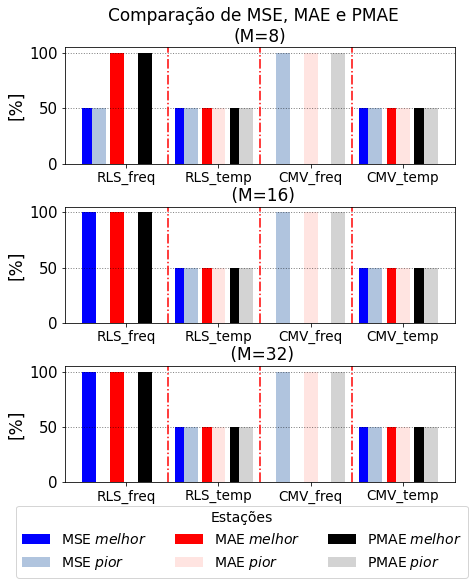

In [118]:
plt.figure(figsize=(7,8))
plt.rcParams['font.size'] = '15'
plt.subplot(311)
resultado_p_UNIDO_mse8x8, metodo_p_UNIDO_mse8x8= filters_UNIDO8x8[0]["pior_1"], filters_UNIDO8x8[0]["pior_0"]
resultado_m_UNIDO_mse8x8, metodo_m_UNIDO_mse8x8 = filters_UNIDO8x8[0]["melhor_1"], filters_UNIDO8x8[0]["melhor_0"]

resultado_p_UNIDO_mae8x8, metodo_p_UNIDO_mae8x8 = filters_UNIDO8x8[1]["pior_1"], filters_UNIDO8x8[1]["pior_0"]
resultado_m_UNIDO_mae8x8, metodo_m_UNIDO_mae8x8 = filters_UNIDO8x8[1]["melhor_1"], filters_UNIDO8x8[1]["melhor_0"]

resultado_p_UNIDO_pmae8x8, metodo_p_UNIDO_pmae8x8 = filters_UNIDO8x8[2]["pior_1"], filters_UNIDO8x8[2]["pior_0"]
resultado_m_UNIDO_pmae8x8, metodo_m_UNIDO_pmae8x8 = filters_UNIDO8x8[2]["melhor_1"], filters_UNIDO8x8[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT8 = 100/caixa8x8_coor_FIXA_besm_6.shape[0]

plt.bar(metodo_m_UNIDO_mse8x8, resultado_m_UNIDO_mse8x8*PORCENT8, color='b', width=0.15, label="MSE_melhor")
plt.bar(metodo_p_UNIDO_mse8x8+0.1, resultado_p_UNIDO_mse8x8*PORCENT8, color='lightsteelblue', width=0.15, label="MSE_pior")
plt.bar(metodo_m_UNIDO_mae8x8+0.3, resultado_m_UNIDO_mae8x8*PORCENT8, color='r', width=0.15, label="MAE_melhor")
plt.bar(metodo_p_UNIDO_mae8x8+0.4, resultado_p_UNIDO_mae8x8*PORCENT8, color='mistyrose', width=0.15, label="MAE_pior")
plt.bar(metodo_m_UNIDO_pmae8x8+0.6, resultado_m_UNIDO_pmae8x8*PORCENT8, color='k', width=0.15, label="PMAE_melhor")
plt.bar(metodo_p_UNIDO_pmae8x8+0.7, resultado_p_UNIDO_pmae8x8*PORCENT8, color='lightgray', width=0.15, label="PMAE_pior")
plt.title("%s%s%s%s"%('(',"M=",nxn8,')'), fontsize=17)
plt.suptitle("Comparação de MSE, MAE e PMAE",y=0.95, fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)
plt.subplots_adjust(hspace=0.37)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.subplot(312); 
resultado_p_UNIDO_mse16x16, metodo_p_UNIDO_mse16x16 = filters_UNIDO16x16[0]["pior_1"], filters_UNIDO16x16[0]["pior_0"]
resultado_m_UNIDO_mse16x16, metodo_m_UNIDO_mse16x16 = filters_UNIDO16x16[0]["melhor_1"], filters_UNIDO16x16[0]["melhor_0"]

resultado_p_UNIDO_mae16x16, metodo_p_UNIDO_mae16x16 = filters_UNIDO16x16[1]["pior_1"], filters_UNIDO16x16[1]["pior_0"]
resultado_m_UNIDO_mae16x16, metodo_m_UNIDO_mae16x16 = filters_UNIDO16x16[1]["melhor_1"], filters_UNIDO16x16[1]["melhor_0"]

resultado_p_UNIDO_pmae16x16, metodo_p_UNIDO_pmae16x16 = filters_UNIDO16x16[2]["pior_1"], filters_UNIDO16x16[2]["pior_0"]
resultado_m_UNIDO_pmae16x16, metodo_m_UNIDO_pmae16x16 = filters_UNIDO16x16[2]["melhor_1"], filters_UNIDO16x16[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT16 = 100/caixa16x16_coor_FIXA_besm_6.shape[0]

plt.bar(metodo_m_UNIDO_mse16x16, resultado_m_UNIDO_mse16x16*PORCENT16, color='b', width=0.15, label="MSE_melhor")
plt.bar(metodo_p_UNIDO_mse16x16+0.1, resultado_p_UNIDO_mse16x16*PORCENT16, color='lightsteelblue', width=0.15, label="MSE_pior")
plt.bar(metodo_m_UNIDO_mae16x16+0.3, resultado_m_UNIDO_mae16x16*PORCENT16, color='r', width=0.15, label="MAE_melhor")
plt.bar(metodo_p_UNIDO_mae16x16+0.4, resultado_p_UNIDO_mae16x16*PORCENT16, color='mistyrose', width=0.15, label="MAE_pior")
plt.bar(metodo_m_UNIDO_pmae16x16+0.6, resultado_m_UNIDO_pmae16x16*PORCENT16, color='k', width=0.15, label="PMAE_melhor")
plt.bar(metodo_p_UNIDO_pmae16x16+0.7, resultado_p_UNIDO_pmae16x16*PORCENT16, color='lightgray', width=0.15, label="PMAE_pior")
plt.title(" %s%s%s%s"%('(',"M=",nxn16,')'), fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)
plt.subplots_adjust(hspace=0.37)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.subplot(313)
resultado_p_UNIDO_mse, metodo_p_UNIDO_mse = filters_UNIDO[0]["pior_1"], filters_UNIDO[0]["pior_0"]
resultado_m_UNIDO_mse, metodo_m_UNIDO_mse = filters_UNIDO[0]["melhor_1"], filters_UNIDO[0]["melhor_0"]

resultado_p_UNIDO_mae, metodo_p_UNIDO_mae = filters_UNIDO[1]["pior_1"], filters_UNIDO[1]["pior_0"]
resultado_m_UNIDO_mae, metodo_m_UNIDO_mae = filters_UNIDO[1]["melhor_1"], filters_UNIDO[1]["melhor_0"]

resultado_p_UNIDO_pmae, metodo_p_UNIDO_pmae = filters_UNIDO[2]["pior_1"], filters_UNIDO[2]["pior_0"]
resultado_m_UNIDO_pmae, metodo_m_UNIDO_pmae = filters_UNIDO[2]["melhor_1"], filters_UNIDO[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT = 100/caixa_coor_FIXA_besm_6.shape[0]

plt.bar(metodo_m_UNIDO_mse, resultado_m_UNIDO_mse*PORCENT, color='b', width=0.15, label="MSE$\;melhor$")
plt.bar(metodo_p_UNIDO_mse+0.1, resultado_p_UNIDO_mse*PORCENT, color='lightsteelblue', width=0.15, label="MSE$\;pior$")
plt.bar(metodo_m_UNIDO_mae+0.3, resultado_m_UNIDO_mae*PORCENT, color='r', width=0.15, label="MAE$\;melhor$")
plt.bar(metodo_p_UNIDO_mae+0.4, resultado_p_UNIDO_mae*PORCENT, color='mistyrose', width=0.15, label="MAE$\;pior$")
plt.bar(metodo_m_UNIDO_pmae+0.6, resultado_m_UNIDO_pmae*PORCENT, color='k', width=0.15, label="PMAE$ \;melhor$")
plt.bar(metodo_p_UNIDO_pmae+0.7, resultado_p_UNIDO_pmae*PORCENT, color='lightgray', width=0.15, label="PMAE$\;pior$")
#plt.title(filters_UNIDO[i]["name"], fontsize=17)#; plt.xlabel("Métodos [/]")
plt.title(" %s%s%s%s"%('(',"M=",nxn,')'), fontsize=17)
#plt.title("Comparação MSE, MAE e PMAE %s%s%s%s%s%s"%('(',"M=",nxn,', $T_p$=',caixa_coor_FIXA_besm_6.shape[0],')'), fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.legend(bbox_to_anchor =(1.05, -0.14), ncol = 3,loc=0, title="Estações", fontsize=14, title_fontsize=14)

plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)

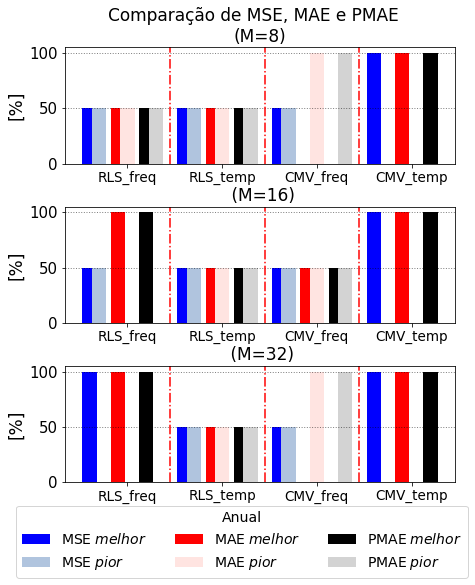

In [119]:
plt.figure(figsize=(7,8))
plt.rcParams['font.size'] = '15'
plt.subplot(311)
resultado_p_mse8x8, metodo_p_mse8x8 = filters8x8[0]["pior_1"], filters8x8[0]["pior_0"]
resultado_m_mse8x8, metodo_m_mse8x8 = filters8x8[0]["melhor_1"], filters8x8[0]["melhor_0"]

resultado_p_mae8x8, metodo_p_mae8x8 = filters8x8[1]["pior_1"], filters8x8[1]["pior_0"]
resultado_m_mae8x8, metodo_m_mae8x8 = filters8x8[1]["melhor_1"], filters8x8[1]["melhor_0"]

resultado_p_pmae8x8, metodo_p_pmae8x8 = filters8x8[2]["pior_1"], filters8x8[2]["pior_0"]
resultado_m_pmae8x8, metodo_m_pmae8x8 = filters8x8[2]["melhor_1"], filters8x8[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT8 = 100/caixa8x8_coor_FIXA_besm_6.shape[0]

plt.bar(metodo_m_mse8x8, resultado_m_mse8x8*PORCENT8, color='b', width=0.15, label="MSE$\;melhor$")
plt.bar(metodo_p_mse8x8+0.1, resultado_p_mse8x8*PORCENT8, color='lightsteelblue', width=0.15, label="MSE_pior")
plt.bar(metodo_m_mae8x8+0.3, resultado_m_mae8x8*PORCENT8, color='r', width=0.15, label="MAE_melhor")
plt.bar(metodo_p_mae8x8+0.4, resultado_p_mae8x8*PORCENT8, color='mistyrose', width=0.15, label="MAE_pior")
plt.bar(metodo_m_pmae8x8+0.6, resultado_m_pmae8x8*PORCENT8, color='k', width=0.15, label="PMAE_melhor")
plt.bar(metodo_p_pmae8x8+0.7, resultado_p_pmae8x8*PORCENT8, color='lightgray', width=0.15, label="PMAE_pior")
plt.title("%s%s%s%s"%('(',"M=",nxn8,')'), fontsize=17)
plt.suptitle("Comparação de MSE, MAE e PMAE",y=0.95, fontsize=17)
#plt.title("Comparação MSE, MAE e PMAE %s%s%s%s%s%s"%('(',"M=",nxn8,', $T_p$=',caixa8x8_coor_FIXA_besm_6.shape[0],')'), fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)
plt.subplots_adjust(hspace=0.37)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.subplot(312); 
resultado_p_mse16x16, metodo_p_mse16x16 = filters16x16[0]["pior_1"], filters16x16[0]["pior_0"]
resultado_m_mse16x16, metodo_m_mse16x16 = filters16x16[0]["melhor_1"], filters16x16[0]["melhor_0"]

resultado_p_mae16x16, metodo_p_mae16x16 = filters16x16[1]["pior_1"], filters16x16[1]["pior_0"]
resultado_m_mae16x16, metodo_m_mae16x16 = filters16x16[1]["melhor_1"], filters16x16[1]["melhor_0"]

resultado_p_pmae16x16, metodo_p_pmae16x16 = filters16x16[2]["pior_1"], filters16x16[2]["pior_0"]
resultado_m_pmae16x16, metodo_m_pmae16x16 = filters16x16[2]["melhor_1"], filters16x16[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT16 = 100/caixa16x16_coor_FIXA_besm_6.shape[0]
    
plt.bar(metodo_m_mse16x16, resultado_m_mse16x16*PORCENT16, color='b', width=0.15, label="MSE$\;melhor$")
plt.bar(metodo_p_mse16x16+0.1, resultado_p_mse16x16*PORCENT16, color='lightsteelblue', width=0.15, label="MSE_pior")
plt.bar(metodo_m_mae16x16+0.3, resultado_m_mae16x16*PORCENT16, color='r', width=0.15, label="MAE_melhor")
plt.bar(metodo_p_mae16x16+0.4, resultado_p_mae16x16*PORCENT16, color='mistyrose', width=0.15, label="MAE_pior")
plt.bar(metodo_m_pmae16x16+0.6, resultado_m_pmae16x16*PORCENT16, color='k', width=0.15, label="PMAE_melhor")
plt.bar(metodo_p_pmae16x16+0.7, resultado_p_pmae16x16*PORCENT16, color='lightgray', width=0.15, label="PMAE_pior")
#plt.title(filters[i]["name"], fontsize=17)#; plt.xlabel("Métodos [/]")
plt.title(" %s%s%s%s"%('(',"M=",nxn16,')'), fontsize=17)
#plt.ylabel("Pixels %s%s%s"%('(T=',caixa_coor_FIXA_besm_6.shape[0],')'), fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)
plt.subplots_adjust(hspace=0.37)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.subplot(313)
resultado_p_mse, metodo_p_mse = filters[0]["pior_1"], filters[0]["pior_0"]
resultado_m_mse, metodo_m_mse = filters[0]["melhor_1"], filters[0]["melhor_0"]

resultado_p_mae, metodo_p_mae = filters[1]["pior_1"], filters[1]["pior_0"]
resultado_m_mae, metodo_m_mae = filters[1]["melhor_1"], filters[1]["melhor_0"]

resultado_p_pmae, metodo_p_pmae = filters[2]["pior_1"], filters[2]["pior_0"]
resultado_m_pmae, metodo_m_pmae = filters[2]["melhor_1"], filters[2]["melhor_0"]
#Incluimos porcentajes para representar mejor las gráficas:
PORCENT = 100/caixa_coor_FIXA_besm_6.shape[0]
    
plt.bar(metodo_m_mse, resultado_m_mse*PORCENT, color='b', width=0.15, label="MSE$\;melhor$")
plt.bar(metodo_p_mse+0.1, resultado_p_mse*PORCENT, color='lightsteelblue', width=0.15, label="MSE$\;pior$")
plt.bar(metodo_m_mae+0.3, resultado_m_mae*PORCENT, color='r', width=0.15, label="MAE$\;melhor$")
plt.bar(metodo_p_mae+0.4, resultado_p_mae*PORCENT, color='mistyrose', width=0.15, label="MAE$\;pior$")
plt.bar(metodo_m_pmae+0.6, resultado_m_pmae*PORCENT, color='k', width=0.15, label="PMAE$\;melhor$")
plt.bar(metodo_p_pmae+0.7, resultado_p_pmae*PORCENT, color='lightgray', width=0.15, label="PMAE$\;pior$")
#plt.title(filters[i]["name"], fontsize=17)#; plt.xlabel("Métodos [/]")
plt.title(" %s%s%s%s"%('(',"M=",nxn,')'), fontsize=17)
#plt.ylabel("Pixels %s%s%s"%('(T=',caixa_coor_FIXA_besm_6.shape[0],')'), fontsize=17)
plt.ylabel("[%]", fontsize=17)
plt.legend(bbox_to_anchor =(1.05, -0.14), ncol = 3,loc=0, title="Anual", fontsize=14, title_fontsize=14)

plt.xticks([ 0.4, 1.4,  2.4, 3.4], MET, fontsize=13.5);
plt.axvline(x=0.85, color="red", linestyle='-.')
plt.axvline(x=1.85, color="red", linestyle='-.')
plt.axvline(x=2.85, color="red", linestyle='-.')
plt.grid(color ='k', linestyle =':', linewidth = 0.99, axis='y', alpha = 0.5)

Text(0.5, 1.0, 'ERA5 e BESM (Ags-Set-Out) (Lat: -59.25 Lon: -46.0)')

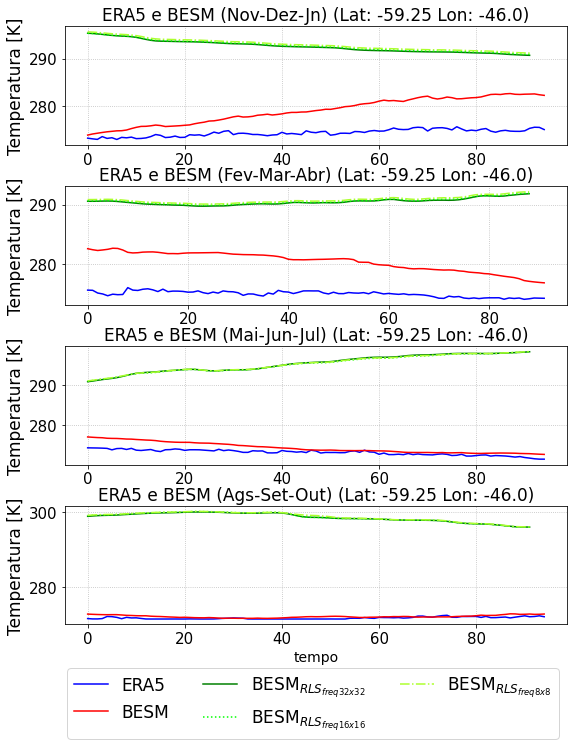

In [120]:
plt.figure(figsize=(9,11))
plt.rcParams['font.size'] = '15'
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es1:Es2,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es1:Es2,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_NDE[Bloque_i][Es1:Es2,3,3],color="green",label='BESM$_{RLS_{freq 32x32}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_NDE16x16[Bloque_i][Es1:Es2,3,3],color="lime",linestyle=':',label='BESM$_{RLS_{freq 16x16}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_NDE8x8[Bloque_i][Es1:Es2,3,3],color="greenyellow",linestyle='-.',label='BESM$_{RLS_{freq 8x8}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Nov-Dez-Jn) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(412)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es3:Es4,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es3:Es4,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_FMA[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq 32x32}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_FMA16x16[Bloque_i][:,3,3],color="lime",linestyle=':',label='BESM$_{RLS_{freq 16x16}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_FMA8x8[Bloque_i][:,3,3],color="greenyellow",linestyle='-.',label='BESM$_{RLS_{freq 8x8}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Fev-Mar-Abr) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es5:Es6,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es5:Es6,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_MJJ[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq 32x32}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_MJJ16x16[Bloque_i][:,3,3],color="lime",linestyle=':',label='BESM$_{RLS_{freq 16x16}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_MJJ8x8[Bloque_i][:,3,3],color="greenyellow",linestyle='-.',label='BESM$_{RLS_{freq 8x8}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Mai-Jun-Jul) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es7:Es8,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es7:Es8,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_ASO[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq 32x32}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_ASO16x16[Bloque_i][:,3,3],color="lime",linestyle=':',label='BESM$_{RLS_{freq 16x16}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_ASO8x8[Bloque_i][:,3,3],color="greenyellow",linestyle='-.',label='BESM$_{RLS_{freq 8x8}}$'),plt.legend(fontsize=17)

plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(1.0, -0.3), ncol = 3, fontsize=17)

plt.xlabel("tempo",fontsize=14)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Ags-Set-Out) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

Text(0.5, 1.0, 'ERA5 e BESM (Ags-Set-Out) (Lat: -59.25 Lon: -46.0)')

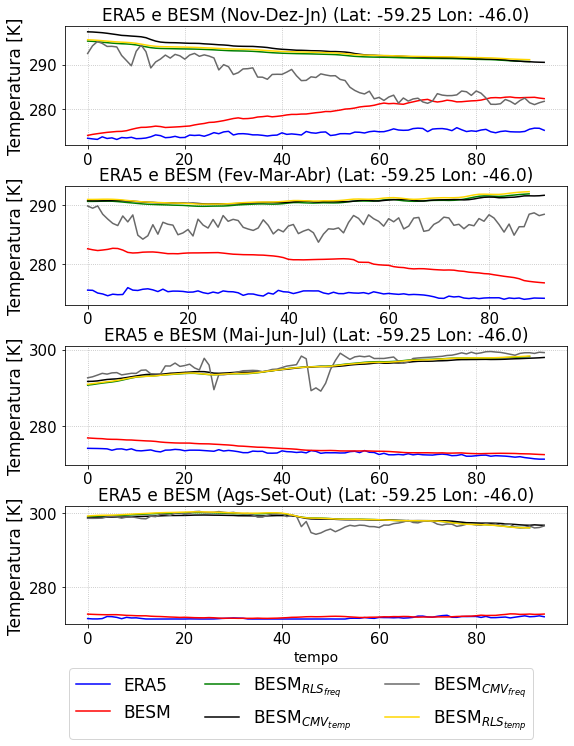

In [121]:
plt.figure(figsize=(9,11))
plt.rcParams['font.size'] = '15'
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es1:Es2,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es1:Es2,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_NDE[Bloque_i][Es1:Es2,3,3],color="green",label='BESM$_{RLS_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_NDE[Bloque_i][3,3,Es1:Es2],color="black",label='BESM$_{MC_{temp}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_NDE[Bloque_i][Es1:Es2,3,3],color="dimgray",label='BESM$_{MC_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_NDE[Bloque_i][3,3,Es1:Es2],color="gold",label='BESM$_{RLS_{temp}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Nov-Dez-Jn) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(412)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es3:Es4,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es3:Es4,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_FMA[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_FMA[Bloque_i][3,3,:],color="black",label='BESM$_{MC_{temp}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_FMA[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_FMA[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Fev-Mar-Abr) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es5:Es6,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es5:Es6,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_MJJ[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_MJJ[Bloque_i][3,3,:],color="black",label='BESM$_{MC_{temp}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_MJJ[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_MJJ[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$')#,plt.legend(fontsize=17)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Mai-Jun-Jul) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.35)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(coorde_BLOQUE_aleat_E7[Es7:Es8,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[Es7:Es8,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_ASO[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_ASO[Bloque_i][3,3,:],color="black",label='BESM$_{CMV_{temp}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_ASO[Bloque_i][:,3,3],color="dimgray",label='BESM$_{CMV_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_ASO[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$'),plt.legend(fontsize=17)

plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(0.95, -0.3), ncol = 3, fontsize=17)

plt.xlabel("tempo",fontsize=14)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("ERA5 e BESM (Ags-Set-Out) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)

(-2.0, 732.0)

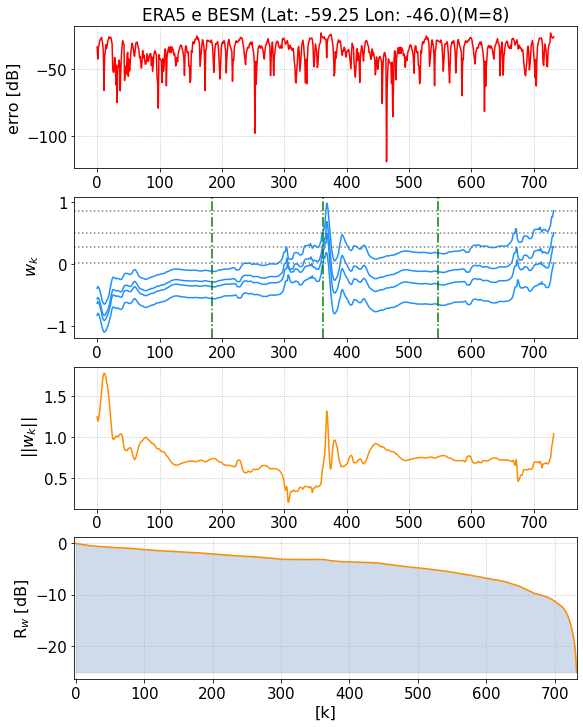

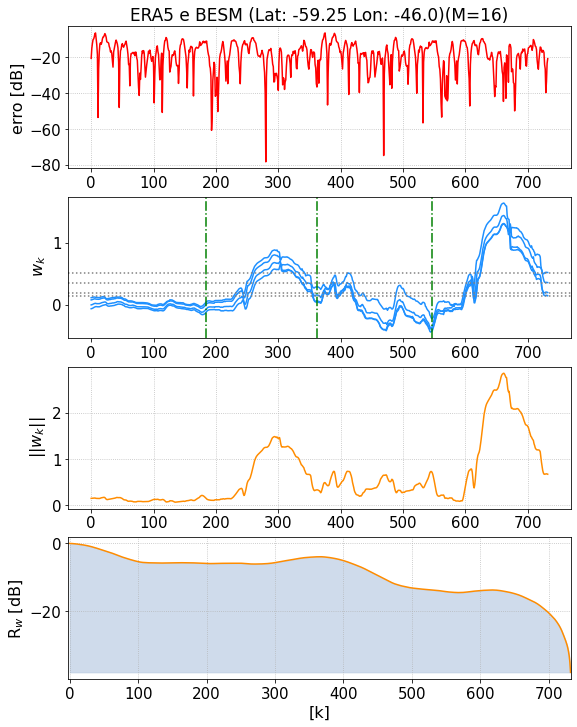

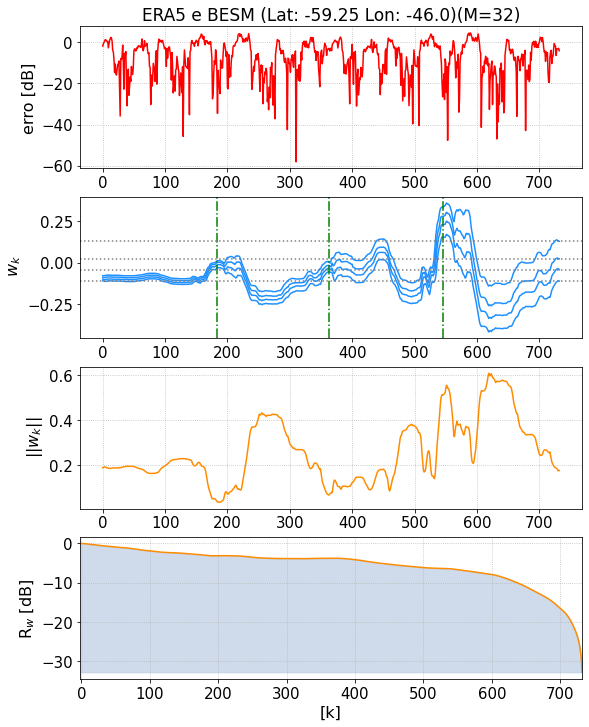

In [122]:
Z_a8x8 = AUTOCORR(norma_paraUnaW_1(B6_Bq_fRLS8x8[Bloque_i],i1,i2))

plt.figure(figsize=(9,12))
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(pa.misc.logSE(B6_Bq_fRLS8x8[Bloque_i][i1][i2][1][0:]),"red", label="Sinal de erro")#;plt.legend()
#plt.legend(loc=3, fontsize=16)
plt.ylabel("erro [dB]", fontsize=16)
plt.title("ERA5 e BESM " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})(M={nxn8})',fontsize=17)
#plt.subplots_adjust(hspace=0.35)

plt.subplot(412); 
#plt.grid(alpha=0.9, linestyle='--') 
plt.plot(B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='L = %.0f'%p)#;plt.legend()
plt.plot(B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
#plt.xlabel("Número de Iteração", fontsize=15)
plt.ylabel(" $w_k$ ",fontsize=16)
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')
#plt.legend(loc=3, title="$\lambda=$%.2f"%mu1, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':') 

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(norma_paraUnaW_1(B6_Bq_fRLS8x8[Bloque_i],i1,i2),"darkorange", label="Módulo do Vetor Coeficiente")#;plt.legend(fontsize=16)
plt.ylabel(" $||w_k||$ ",fontsize=16)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':')
#plt.acorr(10*np.log10(norma_paraUnaW_1(B6_Bq_fRLS[Bloque_i],i1,i2)), maxlags=len(Z_a)-1)#,"green",linestyle="--", label="N = %.0f"%p);plt.legend()
plt.plot(10*np.log10(Z_a8x8/float(Z_a8x8.max())),"darkorange", label="Autocorrelação de $||w||$")#;plt.legend(fontsize=16)
plt.fill_between(np.arange(0,len(Z_a)), 10*np.log10(Z_a8x8/float(Z_a8x8.max())),np.min(10*np.log10(Z_a8x8/float(Z_a8x8.max()))),color='lightsteelblue', alpha=.6)
# obtener la frecuencia de un lado:
#plt.plot(f_oneside, np.abs(X[:n_oneside]),"green", label="N = %.0f"%p);plt.legend()
plt.ylabel("R$_w$ [dB]",fontsize=16)
plt.xlabel("[k]",fontsize=16)
plt.xlim(-2,len(Z_a8x8)-1)

Z_a16x16 = AUTOCORR(norma_paraUnaW_1(B6_Bq_fRLS16x16[Bloque_i],i1,i2))

plt.figure(figsize=(9,12))
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(pa.misc.logSE(B6_Bq_fRLS16x16[Bloque_i][i1][i2][1][0:]),"red", label="Sinal de erro")#;plt.legend()
#plt.legend(loc=3, fontsize=16)
plt.ylabel("erro [dB]", fontsize=16)
plt.title("ERA5 e BESM " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})(M={nxn16})',fontsize=17)
#plt.title("Comparação MSE, MAE e PMAE %s%s%s%s%s%s"%('(',"M=",nxn16,', $T_p$=',caixa16x16_coor_FIXA_besm_6.shape[0],')'), fontsize=17)


plt.subplot(412); 
#plt.grid(alpha=0.9, linestyle='--') 
plt.plot(B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='L = %.0f'%p)#;plt.legend()
plt.plot(B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
#plt.xlabel("Número de Iteração", fontsize=15)
plt.ylabel(" $w_k$ ",fontsize=16)
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')
#plt.legend(loc=3, title="$\lambda=$%.2f"%mu1, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':') 
#plt.subplots_adjust(hspace=0.35)

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(norma_paraUnaW_1(B6_Bq_fRLS16x16[Bloque_i],i1,i2),"darkorange", label="Módulo do Vetor Coeficiente")#;plt.legend(fontsize=16)
plt.ylabel(" $||w_k||$ ",fontsize=16)
#plt.subplots_adjust(hspace=0.35)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':')
#plt.acorr(10*np.log10(norma_paraUnaW_1(B6_Bq_fRLS[Bloque_i],i1,i2)), maxlags=len(Z_a)-1)#,"green",linestyle="--", label="N = %.0f"%p);plt.legend()
plt.plot(10*np.log10(Z_a16x16/float(Z_a16x16.max())),"darkorange", label="Autocorrelação de $||w||$")#;plt.legend(fontsize=16)
plt.fill_between(np.arange(0,len(Z_a)), 10*np.log10(Z_a16x16/float(Z_a16x16.max())),np.min(10*np.log10(Z_a16x16/float(Z_a16x16.max()))),color='lightsteelblue', alpha=.6)
# obtener la frecuencia de un lado:
#plt.plot(f_oneside, np.abs(X[:n_oneside]),"green", label="N = %.0f"%p);plt.legend()
plt.ylabel("R$_w$ [dB]",fontsize=16)
plt.xlabel("[k]",fontsize=16)
plt.xlim(-2,len(Z_a16x16)-1)
#plt.subplots_adjust(hspace=0.35)

plt.figure(figsize=(9,12))
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(pa.misc.logSE(B6_Bq_fRLS[Bloque_i][i1][i2][1][0:]),"red", label="Sinal de erro")#;plt.legend()
#plt.legend(loc=3, fontsize=16)
plt.ylabel("erro [dB]", fontsize=16)
plt.title("ERA5 e BESM " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})(M={nxn})',fontsize=17)
#plt.subplots_adjust(hspace=0.35)

plt.subplot(412); 
#plt.grid(alpha=0.9, linestyle='--') 
plt.plot(B6_Bq_fRLS[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='L = %.0f'%p)#;plt.legend()
plt.plot(B6_Bq_fRLS[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
#plt.xlabel("Número de Iteração", fontsize=15)
plt.ylabel(" $w_k$ ",fontsize=16)
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')
#plt.legend(loc=3, title="$\lambda=$%.2f"%mu1, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':') 
#plt.subplots_adjust(hspace=0.35)

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':') 
plt.plot(norma_paraUnaW_1(B6_Bq_fRLS[Bloque_i],i1,i2),"darkorange", label="Módulo do Vetor Coeficiente")#;plt.legend(fontsize=16)
plt.ylabel(" $||w_k||$ ",fontsize=16)
#plt.subplots_adjust(hspace=0.35)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':')
#plt.acorr(10*np.log10(norma_paraUnaW_1(B6_Bq_fRLS[Bloque_i],i1,i2)), maxlags=len(Z_a)-1)#,"green",linestyle="--", label="N = %.0f"%p);plt.legend()
plt.plot(10*np.log10(Z_a/float(Z_a.max())),"darkorange", label="Autocorrelação de $||w||$")#;plt.legend(fontsize=16)
plt.fill_between(np.arange(0,len(Z_a)), 10*np.log10(Z_a/float(Z_a.max())),np.min(10*np.log10(Z_a/float(Z_a.max()))),color='lightsteelblue', alpha=.6)
# obtener la frecuencia de un lado:
#plt.plot(f_oneside, np.abs(X[:n_oneside]),"green", label="N = %.0f"%p);plt.legend()
plt.ylabel("R$_w$ [dB]",fontsize=16)
plt.xlabel("[k]",fontsize=16)
plt.xlim(-2,len(Z_a)-1)
#plt.subplots_adjust(hspace=0.35)

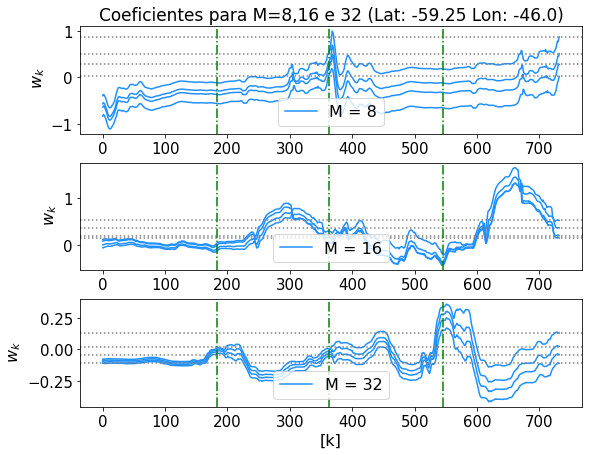

In [123]:
plt.figure(figsize=(9,7))
plt.rcParams['font.size'] = '15'
plt.subplot(311)
plt.title("Coeficientes para M=8,16 e 32 " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.plot(B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='M = %.0f'%nxn8)#;plt.legend()
plt.plot(B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
plt.ylabel(" $w_k$ ",fontsize=16)
plt.legend(loc=8, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS8x8[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':')
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')
plt.subplots_adjust(hspace=0.27)

plt.subplot(312)
plt.plot(B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='M = %.0f'%nxn16)#;plt.legend()
plt.plot(B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
plt.ylabel(" $w_k$ ",fontsize=16)
plt.legend(loc=8, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS16x16[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':') 
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')
plt.subplots_adjust(hspace=0.27)

plt.subplot(313)
plt.plot(B6_Bq_fRLS[Bloque_i][i1][i2][2][:,0],"dodgerblue", label='M = %.0f'%nxn)#;plt.legend()
plt.plot(B6_Bq_fRLS[Bloque_i][i1][i2][2][:,1:p],"dodgerblue")
plt.xlabel("[k]",fontsize=16)
plt.ylabel(" $w_k$ ",fontsize=16)
plt.legend(loc=8, fontsize=16, title_fontsize=16)
for coef in B6_Bq_fRLS[Bloque_i][i1][i2][2][-1]:
        plt.axhline(y=coef, color="gray", linestyle=':') 
plt.axvline(x=92*N_r, color="g", linestyle='-.')
plt.axvline(x=181*N_r, color="g", linestyle='-.')
plt.axvline(x=273*N_r, color="g", linestyle='-.')


Text(0.5, 1.0, 'Ajuste por Estações(Anual) (Lat: -59.25 Lon: -46.0)')

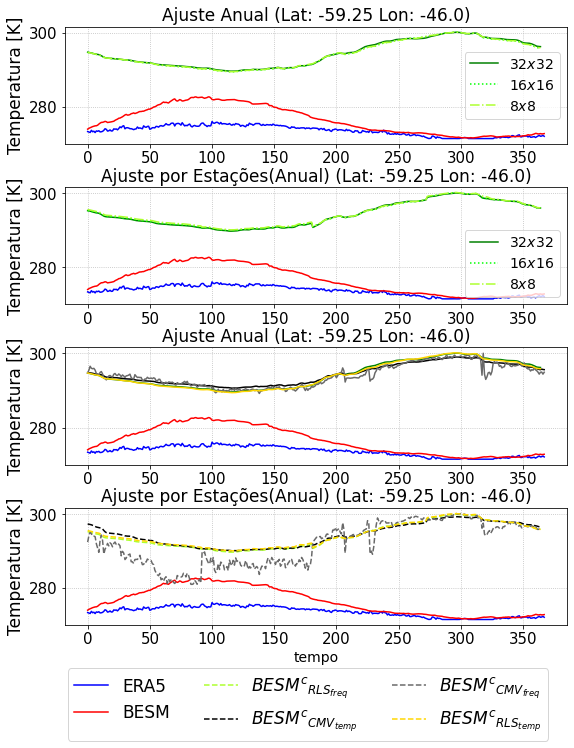

In [124]:
plt.figure(figsize=(9,11))
plt.rcParams['font.size'] = '15'
plt.subplot(411)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue")#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red")#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3],color="green",linestyle='-',label='$32x32$'),plt.legend(fontsize=14)
plt.plot(B7_Bq_conv_idct16x16[Bloque_i][:,3,3],color="lime",linestyle=':',label='$16x16$'),plt.legend(fontsize=14)
plt.plot(B7_Bq_conv_idct8x8[Bloque_i][:,3,3],color="greenyellow",linestyle='-.',label='$8x8$'),plt.legend(fontsize=14)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.37)

plt.subplot(412)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue")#,plt.legend(fontsize=15)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red")#,plt.legend(fontsize=15)
plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3],linestyle='-',color="green",label='$32x32$'),plt.legend(loc=4,fontsize=14)
plt.plot(B7_Bq_conv_idct_UNIDO16x16[Bloque_i][:,3,3],linestyle=':',color="lime",label='$16x16$'),plt.legend(loc=4, fontsize=14)
plt.plot(B7_Bq_conv_idct_UNIDO8x8[Bloque_i][:,3,3],linestyle='-.',color="greenyellow",label='$8x8$'),plt.legend(loc=4, fontsize=14)

plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste por Estações(Anual) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.37)

plt.subplot(413)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5')#,plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3],color="green",label='BESM$_{RLS_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp[Bloque_i][3,3,:],color="black",label='BESM$_{MC_{temp}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct[Bloque_i][:,3,3],color="dimgray",label='BESM$_{MC_{freq}}$')#,plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp[Bloque_i][3,3,:],color="gold",label='BESM$_{RLS_{temp}}$')#,plt.legend(fontsize=17)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.subplots_adjust(hspace=0.37)

plt.subplot(414)
plt.grid(alpha=0.9, linestyle=':')
plt.plot(coorde_BLOQUE_aleat_E7[:,3,3],color="blue",label='ERA5'),plt.legend(fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:,3,3],color="red",label='BESM'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3],linestyle='--',color="greenyellow",label='$BESM^{c}$$_{RLS_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_temp_UNIDO[Bloque_i][:,3,3],linestyle='--',color="black",label='$BESM^{c}$$_{CMV_{temp}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_MC_freq_idct_UNIDO[Bloque_i][:,3,3],linestyle='--',color="dimgray",label='$BESM^{c}$$_{CMV_{freq}}$'),plt.legend(fontsize=17)
plt.plot(B7_Bq_conv_RLS_temp_UNIDO[Bloque_i][:,3,3],linestyle='--',color="gold",label='$BESM^{c}$$_{RLS_{temp}}$'),plt.legend(fontsize=17)
plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(0.98, -0.30), ncol = 3, fontsize=17)
plt.xlabel("tempo", fontsize=14)
plt.ylabel("Temperatura [K]", fontsize=17)
plt.title("Ajuste por Estações(Anual) " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)


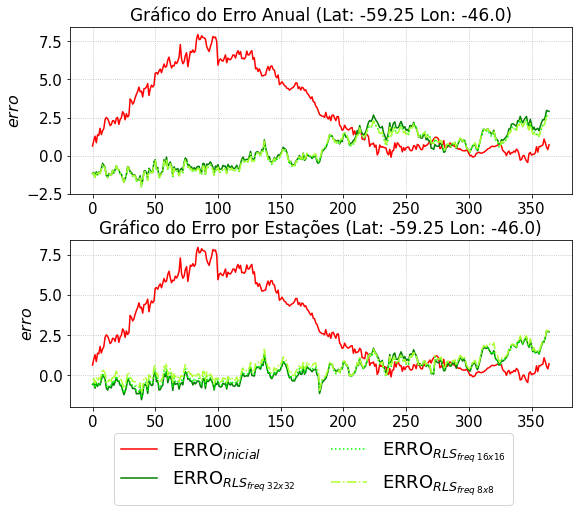

In [125]:
plt.figure(figsize=(9,7))
plt.rcParams['font.size'] = '15'
plt.subplot(211)
plt.grid(alpha=0.9, linestyle=':')
plt.title("Gráfico do Erro Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:D_0,3,3]-coorde_BLOQUE_aleat_E7[:D_0,3,3], "red", label="ERRO$_{inicial}$")
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"green",linestyle='-', label="ERRO$_{RLS_{freq 32x32}}$")
plt.plot(B7_Bq_conv_idct16x16[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"lime",linestyle=':', label="ERRO$_{RLS_{freq 16x16}}$")
plt.plot(B7_Bq_conv_idct8x8[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"greenyellow",linestyle='-.', label="ERRO$_{RLS_{freq 8x8}}$")
plt.ylabel("$erro$", fontsize=16)
plt.subplots_adjust(hspace=0.27)

plt.subplot(212)
plt.grid(alpha=0.9, linestyle=':')
plt.title("Gráfico do Erro por Estações " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:D_0,3,3]-coorde_BLOQUE_aleat_E7[:D_0,3,3], "red", label="ERRO$_{inicial}$")
plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"green",linestyle='-', label="ERRO$_{RLS_{freq\;32x32}}$")
plt.plot(B7_Bq_conv_idct_UNIDO16x16[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"lime",linestyle=':', label="ERRO$_{RLS_{freq\; 16x16}}$")
plt.plot(B7_Bq_conv_idct_UNIDO8x8[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"greenyellow",linestyle='-.', label="ERRO$_{RLS_{freq\; 8x8}}$")
plt.ylabel("$erro$", fontsize=16)
plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(0.90, -0.1), ncol = 2, fontsize=18)

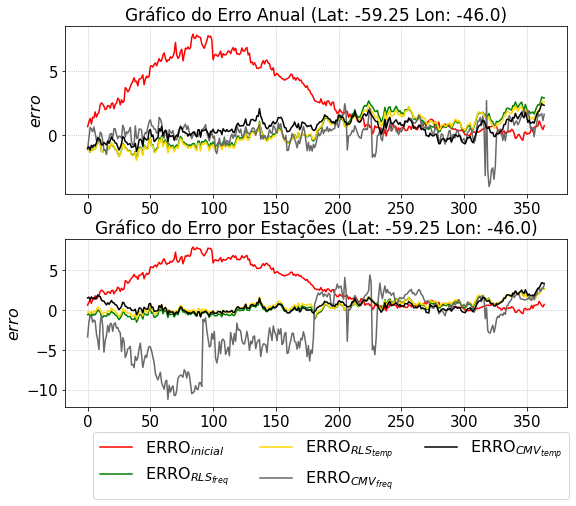

In [126]:
plt.figure(figsize=(9,7))
plt.rcParams['font.size'] = '15'
plt.subplot(211)
plt.grid(alpha=0.9, linestyle=':')
plt.title("Gráfico do Erro Anual " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:D_0,3,3]-coorde_BLOQUE_aleat_E7[:D_0,3,3], "red", label="ERRO$_{inicial}$")
plt.plot(B7_Bq_conv_idct[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"green",linestyle='-', label="ERRO$_{RLS_{freq 32x32}}$")
plt.plot(B7_Bq_conv_RLS_temp[Bloque_i][3,3,:]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "gold", label="ERRO$_{RLS_{\;temp}}$")
plt.plot(B7_Bq_MC_freq_idct[Bloque_i][:D_0,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "dimgray", label="ERRO$_{CMV_{\;freq}}$")
plt.plot(B7_Bq_MC_temp[Bloque_i][3,3,:D_0]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "black", label="ERRO$_{CMV_{\;temp}}$")
plt.ylabel("$erro$", fontsize=16)
plt.subplots_adjust(hspace=0.27)

plt.subplot(212)
plt.grid(alpha=0.9, linestyle=':')
plt.title("Gráfico do Erro por Estações " f'(Lat: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[1]} Lon: {COORDENADA(coorde_BLOQUE_aleat_E7,0,3,3)[0]})',fontsize=17)
plt.plot(coorde_BLOQUE_aleat_B7[:D_0,3,3]-coorde_BLOQUE_aleat_E7[:D_0,3,3], "red", label="ERRO$_{inicial}$")
plt.plot(B7_Bq_conv_idct_UNIDO[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3],"green",linestyle='-', label="ERRO$_{RLS_{freq}}$")
plt.plot(B7_Bq_conv_RLS_temp_UNIDO[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "gold", label="ERRO$_{RLS_{temp}}$")
plt.plot(B7_Bq_MC_freq_idct_UNIDO[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "dimgray", label="ERRO$_{CMV_{freq}}$")
plt.plot(B7_Bq_MC_temp_UNIDO[Bloque_i][:,3,3]-caixa_coor_FIXA_era_7[Bloque_i][:D_0,3,3], "black", label="ERRO$_{CMV_{temp}}$")
plt.ylabel("$erro$", fontsize=16)
plt.legend(loc=1,fontsize=16)
plt.legend(bbox_to_anchor =(1.02, -0.1), ncol = 3, fontsize=16)